# **Discretizing Continuous States**


---


## The Cartpole Task

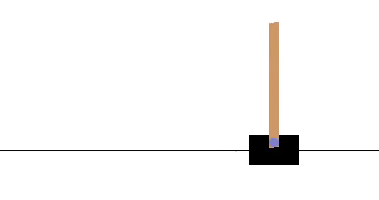

The cartpole task is a classic reinforcement learning challenge. It's a staple task [at OpenGym](https://gym.openai.com/envs/CartPole-v1/) and the code for it is [here on Github.](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)

Here is where it is described in the text (Example 3.5):

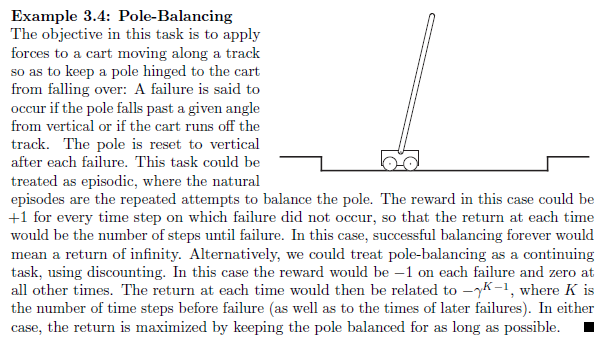

In this tutorial notebook, we will be



1.   Exploring the state space to work out how we might best discretize it.
2.   Specifying and examining several discretization function options.
3.   Specifying an epsilon-greedy SARSA learner.
4.   Using Bayesian optimization to explore the hyperparameter space for us (!!)
5.   Using the results of the above to train a highly effective agent.
6.   Making and watching a little movie of our agent in action!



In [ ]:
import gym
import math

import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
env = gym.make('CartPole-v1')

In [ ]:
"""
If you want to view the docstring for the cartpole environment,
just execute the code below and read up :)
""" 
print(help(env))

In [ ]:
print("Observation Space: ",env.observation_space)
print("Action Space: ",env.action_space)

Observation Space:  Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Action Space:  Discrete(2)


# Exploring the State Space
---
#### What are the state feature distributions?
#### How might we best bucket/bin those features?


First, we collect a little dataset of states. This will probably be usefully representative because the pole starts almost completely upright and will then fall because we are acting randomly.

In [ ]:

states = [] 
n_episodes = 1000
n_steps = 1000

for episode in range(n_episodes):
    current_state = env.reset()
    for t in range(n_steps):
        action = env.action_space.sample()
        new_state, reward, done, _ = env.step(action)
        states.append(new_state)
        if done:
          break

In [ ]:
print("State Dataset Size: ",len(states))
print("Example State: ",states[1])

State Dataset Size:  21907
Example State:  [-0.02460329 -0.34725664  0.00950538  0.62482076]


In [ ]:
# Remember that using the zip function with the * operator on a list of tuples
# returns a list for each tuple element.
position, velocity, angle, angular_velocity = zip(*states)

Next, we define a little convenience function for visualizing the histograms for each state feature. If we are going to usefully discretize those states into buckets, we need to know the bounds.

In [ ]:
from matplotlib import colors 

def create_histogram(x, x_label, title, n_bins, colormap):
  """
  Takes in a list and plots the histogram.
  
  Args:
    x: A list of floats or ints.
    x_label: The label for the x_axis.
    title: The title for the plot.
    n_bins: The number of bins desired.
    colormap: A string that names a matplotlib cmap.
              Examples below.

  Returns:
    No return, just plots the histogram.

  Example cmaps:

    from https://matplotlib.org/stable/tutorials/colors/colormaps.html

    cmaps['Perceptually Uniform Sequential'] = [
              'viridis', 'plasma', 'inferno', 'magma', 'cividis']

    cmaps['Sequential'] = [
              'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
              'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
              'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    
    cmaps['Sequential (2)'] = [
              'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
              'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
              'hot', 'afmhot', 'gist_heat', 'copper']
  """

  fig, axs = plt.subplots(1, 1, 
                          figsize =(7, 4.5),  
                          tight_layout = True) 
    
  # Remove axes splines  
  # https://matplotlib.org/3.3.3/api/spines_api.html
  for s in ['top', 'bottom', 'left', 'right']:  
      axs.spines[s].set_visible(False)  
    
  # Remove x, y ticks 
  # https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.axis.XAxis.set_ticks_position.html
  axs.xaxis.set_ticks_position('none')  
  axs.yaxis.set_ticks_position('none')  
      
  # Add padding between axes and labels  
  # https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.axis.Axis.set_tick_params.html
  axs.xaxis.set_tick_params(pad = 5)  
  axs.yaxis.set_tick_params(pad = 10)  
    
  # Add x, y gridlines  
  # https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.axes.Axes.grid.html
  axs.grid(b = True, color ='grey',  
          linestyle ='-.', linewidth = 0.5,  
          alpha = 0.6)  
    
  # Creating histogram 
  # https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.axes.Axes.hist.html
  N, bins, patches = axs.hist(x, bins = n_bins) 
    
  # Setting color 
  # https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.colors.Normalize.html
  fracs = ((N**(1 / 5)) / N.max()) 
  norm = colors.Normalize(fracs.min(), fracs.max()) 

  for thisfrac, thispatch in zip(fracs, patches): 
      color = plt.cm.get_cmap(colormap)(norm(thisfrac)) 
      thispatch.set_facecolor(color) 
    
  # Adding extra features     
  plt.xlabel(x_label) 
  plt.ylabel("Number of Observations") 
  plt.title(title) 
    
  # Show plot 
  plt.show() 

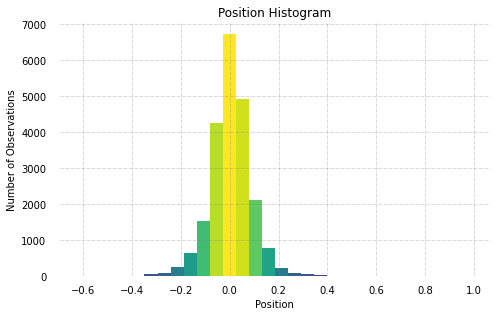

In [ ]:
create_histogram(position, "Position", "Position Histogram", 30, "viridis")

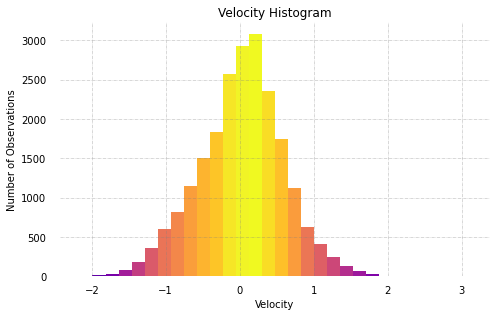

In [ ]:
create_histogram(velocity, "Velocity", "Velocity Histogram", 30, "plasma")

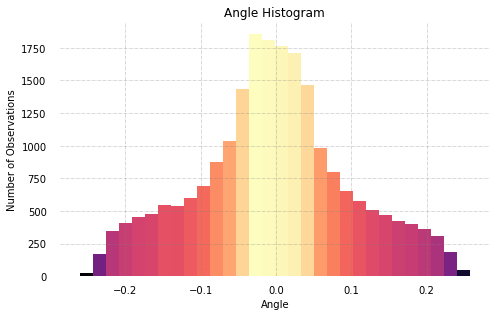

In [ ]:
create_histogram(angle, "Angle", "Angle Histogram", 30, "magma")

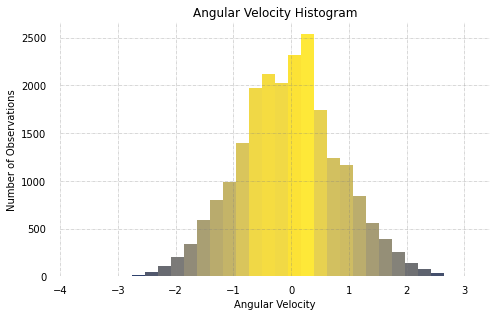

In [ ]:
create_histogram(angular_velocity, "Angular Velocity", "Angular Velocity Histogram", 30, "cividis")

# Discretization Functions

Now that we know the bounds of our features, we can start playing with "binning" or "bucketizing" them. 



## Normalization

We take the values and assign them an integer (a discrete category) based on their position in the distribution. Thus, each state ends up being a tuple of integers. We can use those tuples as keys to our q table defaultdict, exactly as we did in the blackjack example. This is a fairly straightforward approach that basically normalizes the space to [0,1] and then assigns an integer based on where the normalizes observation falls within that range.

To roughly illustrate: if we have 10 bins and a range of [-2,2] (equal bounds on either side of 0), an observation of 0.4 would get assigned a 6:

(bound + obs) / (2*bound / nbins)

(2 + 0.4) / (2*2 / 10) = 6

In [ ]:
"""
I'll just pick some reasonable values so we can visualize what 
our normalization functions are doing.

We can assume that the most useful features in the cartpole problem
are velocity and angular velocity, because they are the things
that actually tell us if our pole is tipping over.

The minmax_bounds are the bounds on either side of 0. So something
like a 2.5 implies a lower bound of -2.5, and an upper bound of 2.5.

I pulled these values from eyeballing the histograms.
"""
buckets = (2, 2, 10, 10)   
minmax_bounds = [1, 2.5, 0.5, 3]


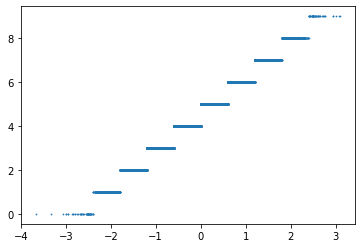

In [ ]:
def discretize_normalize1(state, minmax_bounds, buckets):
  """
  A basic normalization function that is even a bit ugly.

  Args:
    state: A numpy array of floats (a single cartpole observation)
    minmax_bounds: A list of floats for the lower/upper bounds for each feature.
    buckets: An list of integers for the number of buckets for each feature.
  
  Returns:
    A tuple of integers representing the bucket of each state feature.
  """
  discretized = [0 for i in range(len(state))]
  for i in range(len(state)):
      datum = state[i]
      dstate = int(
          math.floor(
              (datum + minmax_bounds[i])/  \
                      (2*minmax_bounds[i]/buckets[i])
            )
          )
      # Sometimes we end up with values of buckets+1
      # or -1, so let's just fix that...
      if dstate >= buckets[i]:
          discretized[i]= buckets[i]-1
      elif dstate < 0:
          discretized[i] = 0
      else:
          discretized[i] = dstate
  return tuple(discretized)

plt.scatter(
    [state[3] for state in states], 
    [ discretize_normalize1(state, minmax_bounds, buckets)[3] for \
           state in states], s = 0.5
            )

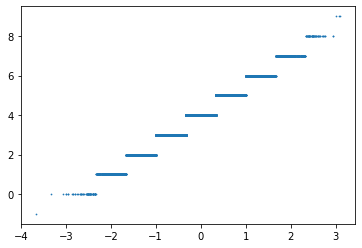

In [ ]:
def discretize_normalize2(state, minmax_bounds, buckets):
  """
  A similar normalization function. Pulled this one off the internet.

  Args:
    state: A numpy array of floats (a single cartpole observation)
    minmax_bounds: A list of floats for the lower/upper bounds for each feature.
    buckets: An list of integers for the number of buckets for each feature.
  
  Returns:
    A tuple of integers representing the bucket of each state feature.
  """
  ratios = [(state[i] + minmax_bounds[i]) / \
            (minmax_bounds[i] - (minmax_bounds[i]*-1)) \
            for i in range(len(state))]
  discretized = [int((buckets[i] - 1) * ratios[i]) \
                  for i in range(len(state))]
  return tuple(discretized)



plt.scatter(
    [state[3] for state in states], 
    [ discretize_normalize2(state, minmax_bounds, buckets)[3] for \
           state in states], s = 0.5
            )

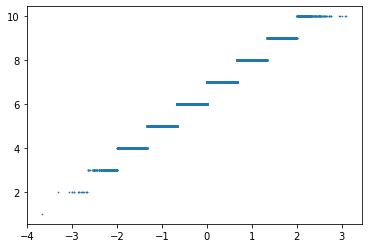

In [ ]:
linspace_buckets = [ 
    np.linspace(minmax_bounds[i]*-1, minmax_bounds[i], buckets[i])
    for i in range(len(buckets))
    ]

def discretize_linspace(state, linspace_buckets):
  """
  Numpy has two great convenience functions for this task:

    np.linspace returns a series of floats, evening (linearly) spaced
    across the min and max values. For example,:
      np.linspace(2,10,5) = array([ 2.,  4.,  6.,  8., 10.])
      https://numpy.org/doc/stable/reference/generated/numpy.linspace.html

    np.digitize will take in this array of bucket dividers and use it
      to properly bucket an array. For example:
      ls = np.linspace(2,10,5)
      np.digitize([.2, 5.5, 7.2, 3.2], ls)
      array([0, 2, 3, 1, 4], dtype=int64)
      https://numpy.org/doc/stable/reference/generated/numpy.digitize.html
  
  Args:
    state: A numpy array of floats (a single cartpole observation)
    linspace_buckets: A list of arrays with bucket bounds, one for each state
    feature, that can be passed to np.digitize.
  
  Returns:
    A tuple of integers representing the bucket of each state feature.
  """
  discretized = []
  for i in range(len(state)):
    discretized.append(np.digitize(state[i], linspace_buckets[i] - 1))
  return tuple(discretized)
 

plt.scatter(
    [state[3] for state in states], 
    [ discretize_linspace(state, linspace_buckets)[3] for \
     state in states], s = 0.5
     )

## Clustering Algorithms




Alternatively, we can use a clustering algorithm to find our number of states. For example, recall that the 
[insurance price optimization paper](https://www.researchgate.net/profile/Fernando_Fernandez9/publication/332122493_Reinforcement_learning_for_pricing_strategy_optimization_in_the_insurance_industry/links/5cecf841458515026a6144d0/Reinforcement-learning-for-pricing-strategy-optimization-in-the-insurance-industry.pdf) used kmeans:

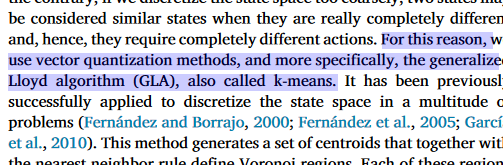

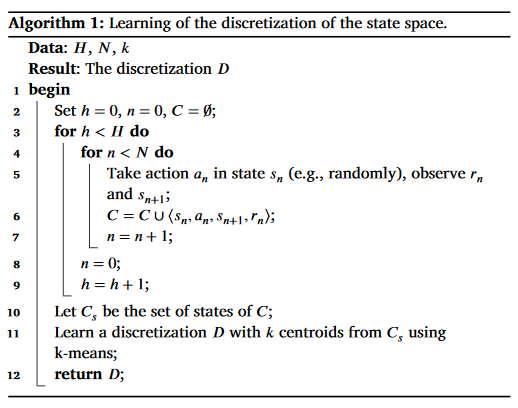

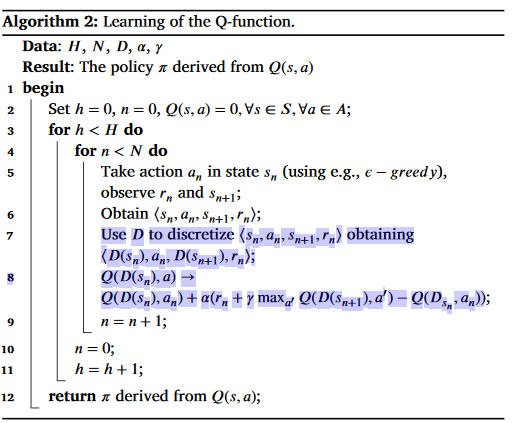

In this approach, we train the kmeans algorithm on our example state dataset we collected earlier. Then, we use it to 'classify' each incoming observation as we run episodes.

In this case, our 'state' is just a single integer representing the assigned class of the of the observation. 

In [ ]:
def discretize_kmeans(state, kmeans, scaler, **kwargs):
  state = state.reshape(1,-1)
  return kmeans.predict(scaler.fit_transform(state))[0]

def discretize_dbscan(state, dbscan_clf, scaler, **kwargs):
  """
  Takes in a state and classifier, and returns the predicted cluster.

  Inputs:
    state: 
  """
  state = state.reshape(1,-1)
  return dbscan_clf.predict(scaler.predict(state))[0]

I didn't end up using DBSCAN in this tutorial because, unlike kmeans, it *cannot* be used to classify new observations; adding a new observation to the dataset requires completely re-estimating the class space which is so inefficient. 

If you do want to play with DBSCAN, the function above references this strategy:

1.   Use DBSCAN to classify the dataset of states.
2.   Use the states + labels to train a classifier (e.g., [xgboost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)).
3.   Use that classifier to classify incoming observations.

This can actually work quite well. DBSCAN is superior to kmeans when it comes to non-linearly separated data (i.e., almost all real data).

However there are newer algorithms (e.g., OPTICS) that might be better.

---


### Kmeans
* [Kmeans on scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
* [Kmeans Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering)
* [Kmeans Paper](http://www.jehps.net/Decembre2008/Bock.pdf)
* [Kmeans Tutorial](https://realpython.com/k-means-clustering-python/)

### DBSCAN
* [DBSCAN on scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
* [DBSCAN Wikipedia](https://en.wikipedia.org/wiki/DBSCAN|)
* [DBSCAN Original Paper](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)
* [DBSCAN Tutorial](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html)


### OPTICS

*   [OPTICS on scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html)
*   [OPTICS Wikipedia](https://en.wikipedia.org/wiki/OPTICS_algorithm)
*   [OPTICS original paper](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.407.5572&rep=rep1&type=pdf)
*   [OPTICS Tutorial](https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html)

# Reinforcement Learner: SARSA Agent

What is provided in the Frozen Lake example, but implemented as a class.

In [ ]:
class EpsilonGreedyTabularSARSA():
  """
  An epsilon-greedy, tabular SARSA agent. "Tabular" means we are using
  discrete states. This agent represents the Q-table as a defaultdict.

  Attributes:
    env: A gym Env() object.
    gamma: float, Discount factor (0,1]
    decay_type: string, "exponential" or "formula"
    decay: float, either [0,1] (if "exponential") or larger 
      (e.g., 100, 200, ..., if "formula")
    min_epsilon: float, The smallest value epsilon can decay to [0,1)
    epsilon: float
    min_alpha: float, The smallest value alpha can decay to (0,1)
    alpha: float
    return_vals: "score" to return the average of the final 100 trials,
      "progress" to return the returns and rolling 100-episode average for all
      episodes.
  """

  def __init__(self,
      env, gamma, decay, decay_type, min_epsilon, epsilon, min_alpha, alpha,
      return_vals):
    self.env = env
    self.gamma = gamma
    self.decay_type = decay_type
    self.decay = decay
    self.min_epsilon = min_epsilon
    self.epsilon = epsilon
    self.min_alpha = min_alpha
    self.alpha = alpha
    self.q = defaultdict(lambda : np.zeros(env.action_space.n))
    self.return_vals = return_vals


  def get_decayed_parameter(self, parameter, min, start, t):
    """
    Decays the parameter passed. Allows for two types of decay, 
    though I only use exponential. 

    eponential: Just multiplies the parameter by some (0,1] value each time
      (e.g., 0.999)
    formula: Uses the formula and the self.decay hyperparameter is larger
      (e.g., 150). 

    Args:
      parameter: A float, epsilon or alpha.
      min: The minimum value we will allow the parameter to take.
      start: The maximum value we will allow the parameter to take.
      t: Current timestep.

    Returns:
      The decayed parameter.
    """

    if self.decay_type == "exponential":
      return parameter*self.decay

    elif self.decay_type == "formula":
      return max(
          min, min(start, 1. - math.log10((t + 1) / self.decay))
          )
  

  def choose_action(self, state, epsilon):
    """
    The epsilon-greedy action selection that we all know and love.
    """
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax( self.q[state] )
    return action


  def update_action_values(self, 
        alpha, state, action, reward, next_state, next_action
        ):
    """
    Update action values according to SARSA (pg. 130 in the text)
    """
    self.q[state][action] += alpha * (reward + \
        self.gamma*self.q[next_state][next_action] - self.q[state][action])


  def run_step(self, 
                  state, action, epsilon, alpha, 
                  discretize_func, **discretize_kwargs
                  ):
    """
    Runs an episode.

    Args:
      state:
      action:
      epsilon:
      alpha:
      discretize_func:
      **discretize_kwargs: This is here so we can provide a dictionary
        of values that need to be passed to the discretize_func. For example,
        if the discretize_func is kmeans we need to pass n_clusters, but if it
        it normalize1 we need to pass minmax_bounds and buckets.
        **kwargs allows us to pass a dictionary containing whatever the waiting
        function might need! So convenient.
        https://realpython.com/python-kwargs-and-args/

    Returns:
      state:
      action: A
      reward: A scalar for the reward from the episode.
      done: A boolean indicating if the episode has terminated.
    """
    next_state, reward, done, _ = self.env.step(action)
    next_state = discretize_func(next_state, **discretize_kwargs)
    next_action = self.choose_action(next_state, epsilon)
    self.update_action_values(
        alpha, state, action, reward, next_state, next_action
        )
    action = next_action
    state = next_state
    return state, action, reward, done

  def run_episode(self, 
                  epsilon, alpha, decay_alpha, decay_epsilon,
                  discretize_func, **discretize_kwargs,):
    """
    Runs a single episode of the cartpole task.

    Args:
      epsilon:
      alpha:
      decay_alpha:
      decay_epsilon:
      discretize_func:
      **discretize_kwargs:

    Returns:
      The return for the episode (scalar).
    """
    t = 0
    episode_return = 0
    state = discretize_func( env.reset(), **discretize_kwargs )
    action = self.choose_action(state, epsilon)

    while True:
      if decay_alpha:
        alpha = self.get_decayed_parameter(
          alpha, self.min_alpha, self.alpha, t
          )
      if decay_epsilon:
        epsilon = self.get_decayed_parameter(
            epsilon, self.min_epsilon, self.epsilon, t
            )
      state, action, reward, done = self.run_step(
          state, action, alpha, epsilon, discretize_func, **discretize_kwargs
          )
      episode_return += reward
      t += 1
      if done:
        break
    return episode_return


  def learn_task(self,
                 num_episodes, decay_alpha, decay_epsilon, discretize_func,
                 **discretize_kwargs):
    """
    Runs num_episodes and learns the cartpole task.

    Args:
      num_episodes:
      decay_alpha: Bool, whether or not to decay alpha.
      decay_epsilon: Bool, whether or not to decay epsilon.
      discretize_func:
      **discretize_kwargs:

    Returns:
      if return_vals = "score", returns the average return for the last
        100 episodes.
      if return_vals = "progress", returns the return and rolling 100-episode
        average return for all episodes. 
    """
    returns = []
    rolling_avg_100 = []
    alpha = self.alpha
    epsilon = self.epsilon
    
    for episode in tqdm( range(1, num_episodes) ):
      
      episode_return = self.run_episode(epsilon, alpha, decay_alpha, decay_epsilon,
                  discretize_func, **discretize_kwargs)
      returns.append(episode_return)

      if episode > 100:
        rolling_avg_100.append(np.mean(returns[-100:]))

    if self.return_vals == "score":
      score = np.mean(returns[-100:])
      return score
    elif self.return_vals == "progress":
      return returns, rolling_avg_100

In [ ]:
agent = EpsilonGreedyTabularSARSA(env = env, gamma = 0.9, decay = .9999, 
          decay_type = "exponential", min_epsilon = .001, epsilon = 0.5,
          min_alpha = 0.1, alpha = 0.3, return_vals = "score")

discretize_kwargs = {
  'buckets' : (2, 2, 8, 10),   
  'minmax_bounds' : [1, 2.5, 0.42, 3]
}

score = agent.learn_task(
    num_episodes = 1000, decay_alpha = True, decay_epsilon = True, 
    discretize_func = discretize_normalize2, **discretize_kwargs
    )

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 999/999 [00:01<00:00, 637.67it/s]


In [ ]:
score

23.88

# Bayesian Optimization of Discretization Approach

You may have noticed that we have a lot of decisions to make when specifying our agent. We have to choose:

1.   Gamma (0,1]
2. Alpha (>0)
3. Epsilon [0,1]
4. Minimum Alpha (alpha > min > 0)
5. Minimum Epsilon (epsilon > min > 0)
6. Decay Parameter (0,1) or some positive integer
7. Decay Strategy (formula or exponential
8. Discretization Strategy, which itself will have a range of parameters like the number of buckets *for each state*, and the upper|lower bound *for each state*

Searching this space requires many decisions. It has so many aspects! Grid search could take forever, random search might be OK but will likely take a long time. Making all the decisions yourself could take hours at a minimum.

So let's do something better. Let's use Bayesian optimization. In brief, Bayesian optimization approaches to hyperparameter search learn the associations between the hyperparameters and the relevant score. They intelligently choose values for each hyperparameter, learning from the prior steps. In this way we can arrive at superior solutions in less time. In other words, a good optimization approach does what you would do if you were making perfect decisions.

The specifics of the [various approaches](https://medium.com/criteo-engineering/hyper-parameter-optimization-algorithms-2fe447525903) to optimization for hyperparameter search are beyond the scope of this course, but here are some materials you can look at if you are interested:

* [Excellent paper on the topic.](https://www.eng.uwaterloo.ca/~jbergstr/files/pub/11_nips_hyperopt.pdf)
* You may also find [this thesis from 2018](https://www.diva-portal.org/smash/get/diva2:1223709/FULLTEXT01.pdf) useful.
* [Good blog post on the general topic.](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)
* [Introduction to the hyperopt package.](https://hyperopt.github.io/hyperopt/)
* [Good blog post using the hyperopt package.](https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a)
* [Introduction to the optuna package.](https://github.com/optuna/optuna/blob/master/examples/quickstart.ipynb)
* [Good blog post using the optuna package.](https://towardsdatascience.com/how-to-make-your-model-awesome-with-optuna-b56d490368af)

If you ever become a data analyst or scientist or researcher or anything of the sort - if you ever deal with hyperparameters, *period* - you want to know about Bayesian Optimization for hyperparameter search. This section is in here because if you don't know about this yet, it's time you learned. 



---



We will be using the Optuna package because I like it best. Optuna uses a [Tree-Structured Parzen Estimator approach](https://www.eng.uwaterloo.ca/~jbergstr/files/pub/11_nips_hyperopt.pdf) by default. 

In short, with optuna we specify a function (typically called "objective") that we want to optimize over. Hyperparameter choices go in, a single score goes out. We tell it we want to minimize or maximize the score, and off we go.

It's so easy now!! 

We will want to maximize our reward, and as a score we will use the average reward over the last 100 trials. According to [this](https://gym.openai.com/evaluations/eval_lEi8I8v2QLqEgzBxcvRIaA/) Cartpole-v0 is considered solved if you can achieve an average reward of 195 over 100 consecutive trials.

Let's see how high we can push it.






In [ ]:
!pip install optuna

     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 296kB 6.1MB/s 
     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 81kB 4.6MB/s 
     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 163kB 9.1MB/s 
     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 112kB 10.3MB/s 
     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 143kB 9.7MB/s 
     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 51kB 3.9MB/s 
     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 81kB 4.7MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=c46ec293939aa051b86b986d545b7892ec90d47b09a1aaf65cdf8da0031a85e6
  Stored in 

In [ ]:
import optuna

In [ ]:
def objective(trial):
  NUM_EPISODES = 2000
  scaler = StandardScaler()
  scaled_states = scaler.fit_transform(states)

  agent = EpsilonGreedyTabularSARSA(
        env = env, 
        # Each trial, the algorithm suggests a value from 
        # the ranges I've specified.
        # Note that these ranges are where your good judgment as an analyst
        # comes in.
        gamma = trial.suggest_float('gamma',0.8,1.), 
        decay = trial.suggest_float('decay_rate',0.9,1.), 
        decay_type = "exponential", 
        min_epsilon = trial.suggest_float('min_epsilon',0.001,0.1), 
        epsilon = trial.suggest_float('epsilon',0.2,1.),
        min_alpha = trial.suggest_float('min_alpha',0.001,0.1), 
        alpha = trial.suggest_float('alpha',0.2,1.),
        return_vals = "score"
      )
  buckets = [
      trial.suggest_int('position', 1,30),
      trial.suggest_int('velocity',1,30),
      # Went with higher values for angle and angular velocity
      # because I suspect they are more important.
      trial.suggest_int('angle', 5,50), 
      trial.suggest_int('angular_velocity', 5,50)
    ]
  minmax_bounds = [
    # These bounds are drawn from the histograms.
    trial.suggest_float("position_bounds",0.5,2),
    trial.suggest_float("velocity_bounds",1,3),
    trial.suggest_float("angle_bounds",0.1,0.5),
    trial.suggest_float("angular_velocity_bounds",2,4)
  ]
  discretize_option = trial.suggest_categorical(
      # We'll just test 2 to start.
     "discretize", ["kmeans","normalize1"]
     )
  kmeans_kwargs = {
      "init": "random",
      "n_init": 10,
      "max_iter": 300,
      "random_state": 42,
    }

  if discretize_option == "kmeans":
    print("Running kmeans...")
    k = trial.suggest_int('k',500,10000, step = 100)
    # NOTE that we are not making any features more important, here.
    # You might try clustering only on angle / angular velocity...
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs).fit(scaled_states)
    discretize_kwargs = {'kmeans' : kmeans, "scaler" : scaler}
    score = agent.learn_task(
      num_episodes = NUM_EPISODES, 
      decay_alpha = True, 
      decay_epsilon = True, 
      discretize_func = discretize_kmeans, **discretize_kwargs
      )
    #print("kmeans Score: ",score)

  elif discretize_option == "normalize1":
    print("Running normalize1...")
    discretize_kwargs = {
        'buckets' : buckets,
        'minmax_bounds' : minmax_bounds
    }
    score = agent.learn_task(
      num_episodes = NUM_EPISODES, 
      decay_alpha = True, 
      decay_epsilon = True, 
      discretize_func = discretize_normalize1, **discretize_kwargs
      )
    #print("Normalize1 Score: ",score)

  return score


In [ ]:
study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler(seed = 42))
study.optimize(
    objective,
    n_trials = 1000 # Maybe you'll want more trials. 
    )
print(study.best_trial)

[I 2021-03-19 23:32:20,936] A new study created in memory with name: no-name-786ce67d-ee3a-45a4-9016-3451aa88c9a3
  6%|â–Œ         | 117/1999 [00:00<00:01, 1167.06it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:02<00:00, 669.82it/s]
[I 2021-03-19 23:32:23,971] Trial 0 finished with value: 33.78 and parameters: {'gamma': 0.8749080237694725, 'decay_rate': 0.9950714306409916, 'min_epsilon': 0.07346740023932911, 'epsilon': 0.6789267873576292, 'min_alpha': 0.016445845403801215, 'alpha': 0.32479561626896214, 'position': 11, 'velocity': 11, 'angle': 28, 'angular_velocity': 40, 'position_bounds': 0.7143002268829112, 'velocity_bounds': 2.3017769458977058, 'angle_bounds': 0.12256463161084011, 'angular_velocity_bounds': 3.4439975445336497, 'discretize': 'normalize1'}. Best is trial 0 with value: 33.78.
 12%|â–ˆâ–        | 240/1999 [00:00<00:01, 1148.20it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:03<00:00, 582.17it/s]
[I 2021-03-19 23:32:27,450] Trial 1 finished with value: 71.05 and parameters: {'gamma': 0.8424678221356553, 'decay_rate': 0.9181824967207101, 'min_epsilon': 0.01915704647548995, 'epsilon': 0.4433937943676302, 'min_alpha': 0.05295088673159155, 'alpha': 0.5455560149136927, 'position': 17, 'velocity': 27, 'angle': 46, 'angular_velocity': 32, 'position_bounds': 1.9606332782621887, 'velocity_bounds': 1.4655426808606085, 'angle_bounds': 0.13624257381312832, 'angular_velocity_bounds': 3.2367720186661746, 'discretize': 'normalize1'}. Best is trial 1 with value: 71.05.
 11%|â–ˆ         | 216/1999 [00:00<00:01, 1079.93it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:04<00:00, 419.07it/s]
[I 2021-03-19 23:32:32,264] Trial 2 finished with value: 83.2 and parameters: {'gamma': 0.9028468876827224, 'decay_rate': 0.9592414568862042, 'min_epsilon': 0.005598590859279775, 'epsilon': 0.6860358815211507, 'min_alpha': 0.017881888245041864, 'alpha': 0.25204127438822366, 'position': 4, 'velocity': 25, 'angle': 18, 'angular_velocity': 13, 'position_bounds': 0.5239493783303213, 'velocity_bounds': 1.461787651244298, 'angle_bounds': 0.1964101864104047, 'angular_velocity_bounds': 3.3665270376509167, 'discretize': 'normalize1'}. Best is trial 2 with value: 83.2.
  7%|â–‹         | 149/1999 [00:00<00:01, 1469.80it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:05<00:00, 361.92it/s]
[I 2021-03-19 23:32:37,825] Trial 3 finished with value: 101.02 and parameters: {'gamma': 0.8990353820222541, 'decay_rate': 0.9034388521115219, 'min_epsilon': 0.09102271980579943, 'epsilon': 0.40702398528001354, 'min_alpha': 0.06658970615104422, 'alpha': 0.4493688608715288, 'position': 6, 'velocity': 22, 'angle': 46, 'angular_velocity': 8, 'position_bounds': 0.7772816832882905, 'velocity_bounds': 2.939169255529117, 'angle_bounds': 0.4100531293444458, 'angular_velocity_bounds': 3.8789978831283785, 'discretize': 'normalize1'}. Best is trial 3 with value: 101.02.


Running kmeans...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [01:03<00:00, 31.25it/s]
[I 2021-03-19 23:38:40,319] Trial 4 finished with value: 18.42 and parameters: {'gamma': 0.9853317731587589, 'decay_rate': 0.9727271995856421, 'min_epsilon': 0.0333275361117777, 'epsilon': 0.6563551795243195, 'min_alpha': 0.05256259174255655, 'alpha': 0.9689376194794794, 'position': 21, 'velocity': 16, 'angle': 49, 'angular_velocity': 22, 'position_bounds': 1.3095381985836196, 'velocity_bounds': 2.1735023313276964, 'angle_bounds': 0.48610212290565524, 'angular_velocity_bounds': 3.214068495373369, 'discretize': 'kmeans', 'k': 4500}. Best is trial 3 with value: 101.02.


Running kmeans...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:39<00:00, 50.98it/s]
[I 2021-03-19 23:43:46,510] Trial 5 finished with value: 11.85 and parameters: {'gamma': 0.8592547011408165, 'decay_rate': 0.9165266939063003, 'min_epsilon': 0.002548004267378199, 'epsilon': 0.5387211845650957, 'min_alpha': 0.0400932702993814, 'alpha': 0.4347905397744305, 'position': 11, 'velocity': 19, 'angle': 21, 'angular_velocity': 12, 'position_bounds': 1.5935107520614809, 'velocity_bounds': 2.5425406933718913, 'angle_bounds': 0.12961786069363615, 'angular_velocity_bounds': 2.7169314570885454, 'discretize': 'kmeans', 'k': 3200}. Best is trial 3 with value: 101.02.


Running kmeans...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:23<00:00, 85.66it/s]
[I 2021-03-19 23:46:00,750] Trial 6 finished with value: 11.95 and parameters: {'gamma': 0.9726206851751187, 'decay_rate': 0.9623298126827557, 'min_epsilon': 0.03375890446041227, 'epsilon': 0.25084668022881895, 'min_alpha': 0.03178724984985056, 'alpha': 0.46014665762139767, 'position': 3, 'velocity': 12, 'angle': 44, 'angular_velocity': 26, 'position_bounds': 1.8308191138644898, 'velocity_bounds': 1.9444298503238986, 'angle_bounds': 0.14783769837532068, 'angular_velocity_bounds': 3.42648957444599, 'discretize': 'kmeans', 'k': 900}. Best is trial 3 with value: 101.02.


Running kmeans...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:23<00:00, 84.54it/s]
[I 2021-03-19 23:49:23,873] Trial 7 finished with value: 11.25 and parameters: {'gamma': 0.9122554395138993, 'decay_rate': 0.9770967179954562, 'min_epsilon': 0.049885764040074686, 'epsilon': 0.6181862635055952, 'min_alpha': 0.04332656081749642, 'alpha': 0.22033530139527616, 'position': 13, 'velocity': 19, 'angle': 36, 'angular_velocity': 43, 'position_bounds': 1.2130553347731676, 'velocity_bounds': 2.126551143952767, 'angle_bounds': 0.378206434570451, 'angular_velocity_bounds': 2.2786629088117514, 'discretize': 'kmeans', 'k': 1900}. Best is trial 3 with value: 101.02.
  6%|â–Œ         | 114/1999 [00:00<00:01, 1133.74it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:03<00:00, 512.09it/s]
[I 2021-03-19 23:49:27,823] Trial 8 finished with value: 52.53 and parameters: {'gamma': 0.9511102277086098, 'decay_rate': 0.9228798165491623, 'min_epsilon': 0.008621011073050506, 'epsilon': 0.43180116233101445, 'min_alpha': 0.01696090743814644, 'alpha': 0.9437581218740585, 'position': 13, 'velocity': 30, 'angle': 10, 'angular_velocity': 32, 'position_bounds': 1.7055081153486717, 'velocity_bounds': 1.3731401177720717, 'angle_bounds': 0.45702359939599113, 'angular_velocity_bounds': 3.078684483831301, 'discretize': 'normalize1'}. Best is trial 3 with value: 101.02.
 11%|â–ˆâ–        | 227/1999 [00:00<00:01, 1085.30it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:03<00:00, 556.11it/s]
[I 2021-03-19 23:49:31,469] Trial 9 finished with value: 40.41 and parameters: {'gamma': 0.8244175909401347, 'decay_rate': 0.9356297838076975, 'min_epsilon': 0.09077601571302965, 'epsilon': 0.41770579950770825, 'min_alpha': 0.06512132193359488, 'alpha': 0.20041630159625268, 'position': 13, 'velocity': 9, 'angle': 7, 'angular_velocity': 43, 'position_bounds': 0.7469837797144125, 'velocity_bounds': 2.068178838750884, 'angle_bounds': 0.29393198854359326, 'angular_velocity_bounds': 3.3848720657805407, 'discretize': 'normalize1'}. Best is trial 3 with value: 101.02.
  9%|â–‰         | 185/1999 [00:00<00:01, 951.09it/s] 

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:03<00:00, 662.98it/s]
[I 2021-03-19 23:49:34,544] Trial 10 finished with value: 41.59 and parameters: {'gamma': 0.9355536036009877, 'decay_rate': 0.9003297593968816, 'min_epsilon': 0.09698417396799876, 'epsilon': 0.935712004894373, 'min_alpha': 0.09707180685900334, 'alpha': 0.7541114883549628, 'position': 29, 'velocity': 3, 'angle': 35, 'angular_velocity': 5, 'position_bounds': 1.0501423719045584, 'velocity_bounds': 2.891619439947427, 'angle_bounds': 0.3653032857595852, 'angular_velocity_bounds': 3.983868483775727, 'discretize': 'normalize1'}. Best is trial 3 with value: 101.02.
  7%|â–‹         | 132/1999 [00:00<00:01, 1316.35it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:07<00:00, 275.53it/s]
[I 2021-03-19 23:49:41,861] Trial 11 finished with value: 99.37 and parameters: {'gamma': 0.8979904190255397, 'decay_rate': 0.9402905358730932, 'min_epsilon': 0.07117204575711572, 'epsilon': 0.8423128825174769, 'min_alpha': 0.08432936647603925, 'alpha': 0.3318716769690393, 'position': 2, 'velocity': 25, 'angle': 17, 'angular_velocity': 12, 'position_bounds': 0.5647333263585417, 'velocity_bounds': 1.1332549316002336, 'angle_bounds': 0.22911175054780927, 'angular_velocity_bounds': 3.9904497544493918, 'discretize': 'normalize1'}. Best is trial 3 with value: 101.02.
  3%|â–Ž         | 59/1999 [00:00<00:03, 553.00it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:08<00:00, 233.35it/s]
[I 2021-03-19 23:49:50,488] Trial 12 finished with value: 123.44 and parameters: {'gamma': 0.8846913124978973, 'decay_rate': 0.9005449141404619, 'min_epsilon': 0.0761996844500953, 'epsilon': 0.9199919315272397, 'min_alpha': 0.08510912530806551, 'alpha': 0.6847982514469155, 'position': 1, 'velocity': 23, 'angle': 15, 'angular_velocity': 6, 'position_bounds': 0.5015764622075665, 'velocity_bounds': 2.8224161459433, 'angle_bounds': 0.2785058076588207, 'angular_velocity_bounds': 3.972034044325542, 'discretize': 'normalize1'}. Best is trial 12 with value: 123.44.
  8%|â–Š         | 163/1999 [00:00<00:02, 829.44it/s] 

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:05<00:00, 390.34it/s]
[I 2021-03-19 23:49:55,669] Trial 13 finished with value: 70.59 and parameters: {'gamma': 0.8000292987781852, 'decay_rate': 0.9043691338106334, 'min_epsilon': 0.07760908212823352, 'epsilon': 0.2473257388913097, 'min_alpha': 0.07534872636524008, 'alpha': 0.76441793430355, 'position': 7, 'velocity': 20, 'angle': 28, 'angular_velocity': 6, 'position_bounds': 0.8911260741928, 'velocity_bounds': 2.996599873713497, 'angle_bounds': 0.3293748050797338, 'angular_velocity_bounds': 3.838764599106141, 'discretize': 'normalize1'}. Best is trial 12 with value: 123.44.
  7%|â–‹         | 132/1999 [00:00<00:02, 634.29it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:04<00:00, 421.52it/s]
[I 2021-03-19 23:50:00,479] Trial 14 finished with value: 52.48 and parameters: {'gamma': 0.8827178103542909, 'decay_rate': 0.906106995641631, 'min_epsilon': 0.08627626672074468, 'epsilon': 0.9914163854954458, 'min_alpha': 0.09645047493880406, 'alpha': 0.6871023166069369, 'position': 7, 'velocity': 22, 'angle': 12, 'angular_velocity': 18, 'position_bounds': 0.5000144852590818, 'velocity_bounds': 2.7050683270114178, 'angle_bounds': 0.4459683669712669, 'angular_velocity_bounds': 3.7200335006782983, 'discretize': 'normalize1'}. Best is trial 12 with value: 123.44.
  6%|â–Œ         | 124/1999 [00:00<00:03, 571.64it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:09<00:00, 217.53it/s]
[I 2021-03-19 23:50:09,731] Trial 15 finished with value: 142.52 and parameters: {'gamma': 0.9323021654933301, 'decay_rate': 0.9002060877233371, 'min_epsilon': 0.05893189786647954, 'epsilon': 0.8530072673407704, 'min_alpha': 0.07854666030712898, 'alpha': 0.6172133007807223, 'position': 1, 'velocity': 28, 'angle': 38, 'angular_velocity': 6, 'position_bounds': 0.8714179536133174, 'velocity_bounds': 2.686566995148044, 'angle_bounds': 0.26827219557656773, 'angular_velocity_bounds': 2.697508931204566, 'discretize': 'normalize1'}. Best is trial 15 with value: 142.52.
  5%|â–Œ         | 104/1999 [00:00<00:01, 1035.08it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:05<00:00, 376.15it/s]
[I 2021-03-19 23:50:15,100] Trial 16 finished with value: 78.41 and parameters: {'gamma': 0.9372469330870504, 'decay_rate': 0.9312100178519349, 'min_epsilon': 0.059141598615535106, 'epsilon': 0.8154573160244146, 'min_alpha': 0.08640207050741568, 'alpha': 0.855321108778374, 'position': 1, 'velocity': 30, 'angle': 36, 'angular_velocity': 50, 'position_bounds': 0.9871754274219527, 'velocity_bounds': 2.495130024561722, 'angle_bounds': 0.2648269376096059, 'angular_velocity_bounds': 2.6862140869570603, 'discretize': 'normalize1'}. Best is trial 15 with value: 142.52.
  5%|â–         | 97/1999 [00:00<00:01, 954.84it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:03<00:00, 554.94it/s]
[I 2021-03-19 23:50:18,763] Trial 17 finished with value: 49.49 and parameters: {'gamma': 0.9240592783597823, 'decay_rate': 0.9152196082937273, 'min_epsilon': 0.05802389195901807, 'epsilon': 0.8276344512487446, 'min_alpha': 0.08245597645466113, 'alpha': 0.6102896124394506, 'position': 26, 'velocity': 27, 'angle': 24, 'angular_velocity': 19, 'position_bounds': 1.144972520394342, 'velocity_bounds': 2.6919205268840867, 'angle_bounds': 0.20976108806346855, 'angular_velocity_bounds': 2.1408115887225705, 'discretize': 'normalize1'}. Best is trial 15 with value: 142.52.
  6%|â–‹         | 127/1999 [00:00<00:03, 589.92it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:06<00:00, 309.10it/s]
[I 2021-03-19 23:50:25,292] Trial 18 finished with value: 66.09 and parameters: {'gamma': 0.9519818532714183, 'decay_rate': 0.9432929062502434, 'min_epsilon': 0.051556808887704225, 'epsilon': 0.946668996867281, 'min_alpha': 0.06785927385109294, 'alpha': 0.6214364592393383, 'position': 1, 'velocity': 30, 'angle': 39, 'angular_velocity': 5, 'position_bounds': 1.4336815698365113, 'velocity_bounds': 1.759905699825353, 'angle_bounds': 0.2668591095622864, 'angular_velocity_bounds': 2.723551853806864, 'discretize': 'normalize1'}. Best is trial 15 with value: 142.52.
  5%|â–         | 90/1999 [00:00<00:02, 899.95it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:02<00:00, 830.70it/s]
[I 2021-03-19 23:50:27,763] Trial 19 finished with value: 29.69 and parameters: {'gamma': 0.8717985904442144, 'decay_rate': 0.9932521428262729, 'min_epsilon': 0.04080021770660146, 'epsilon': 0.7480395782092853, 'min_alpha': 0.09861330209970694, 'alpha': 0.8256256144796964, 'position': 21, 'velocity': 16, 'angle': 31, 'angular_velocity': 16, 'position_bounds': 0.6400880603226746, 'velocity_bounds': 2.3833102512462587, 'angle_bounds': 0.322775758812955, 'angular_velocity_bounds': 2.5196861596573243, 'discretize': 'normalize1'}. Best is trial 15 with value: 142.52.
  4%|â–         | 86/1999 [00:00<00:02, 859.15it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:04<00:00, 441.61it/s]
[I 2021-03-19 23:50:32,352] Trial 20 finished with value: 53.03 and parameters: {'gamma': 0.9956541236187939, 'decay_rate': 0.9279051596661473, 'min_epsilon': 0.0679295205257196, 'epsilon': 0.9067726617682972, 'min_alpha': 0.08984725884647994, 'alpha': 0.5154683766961073, 'position': 5, 'velocity': 25, 'angle': 5, 'angular_velocity': 9, 'position_bounds': 0.9045710207935248, 'velocity_bounds': 2.722822779596495, 'angle_bounds': 0.24958585095122734, 'angular_velocity_bounds': 2.871007971153924, 'discretize': 'normalize1'}. Best is trial 15 with value: 142.52.
  6%|â–‹         | 126/1999 [00:00<00:01, 1244.82it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:06<00:00, 310.35it/s]
[I 2021-03-19 23:50:38,861] Trial 21 finished with value: 84.14 and parameters: {'gamma': 0.8955121614564931, 'decay_rate': 0.9008104160758659, 'min_epsilon': 0.08410462805342923, 'epsilon': 0.34097266458892816, 'min_alpha': 0.06439091168070636, 'alpha': 0.6762354767883506, 'position': 7, 'velocity': 22, 'angle': 42, 'angular_velocity': 8, 'position_bounds': 0.7898088616268012, 'velocity_bounds': 2.9632156966159675, 'angle_bounds': 0.4054669756311463, 'angular_velocity_bounds': 3.6754808537529344, 'discretize': 'normalize1'}. Best is trial 15 with value: 142.52.
  4%|â–         | 84/1999 [00:00<00:02, 838.05it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:05<00:00, 340.62it/s]
[I 2021-03-19 23:50:44,787] Trial 22 finished with value: 71.75 and parameters: {'gamma': 0.9174167881754931, 'decay_rate': 0.9100864710257266, 'min_epsilon': 0.09578108590683243, 'epsilon': 0.5597219311453978, 'min_alpha': 0.07438637662069932, 'alpha': 0.424087261466508, 'position': 1, 'velocity': 22, 'angle': 47, 'angular_velocity': 5, 'position_bounds': 0.8505794092991441, 'velocity_bounds': 2.8272356672465855, 'angle_bounds': 0.30433125084766677, 'angular_velocity_bounds': 2.4844044201021194, 'discretize': 'normalize1'}. Best is trial 15 with value: 142.52.
  6%|â–Œ         | 120/1999 [00:00<00:01, 1188.25it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:06<00:00, 323.35it/s]
[I 2021-03-19 23:50:51,035] Trial 23 finished with value: 54.01 and parameters: {'gamma': 0.8523259122728374, 'decay_rate': 0.9004958727602197, 'min_epsilon': 0.08057279725981481, 'epsilon': 0.9914171970457428, 'min_alpha': 0.07416065154273221, 'alpha': 0.559296144577292, 'position': 5, 'velocity': 27, 'angle': 41, 'angular_velocity': 10, 'position_bounds': 0.6425795165723384, 'velocity_bounds': 2.9771431664069916, 'angle_bounds': 0.1749506370806038, 'angular_velocity_bounds': 2.9444698552866626, 'discretize': 'normalize1'}. Best is trial 15 with value: 142.52.
  4%|â–         | 83/1999 [00:00<00:02, 827.04it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:05<00:00, 333.96it/s]
[I 2021-03-19 23:50:57,081] Trial 24 finished with value: 82.76 and parameters: {'gamma': 0.8791671266192598, 'decay_rate': 0.9123113016898314, 'min_epsilon': 0.06342326884419003, 'epsilon': 0.758766618259892, 'min_alpha': 0.05870476741628244, 'alpha': 0.6788263048364609, 'position': 9, 'velocity': 23, 'angle': 32, 'angular_velocity': 15, 'position_bounds': 1.035504923841651, 'velocity_bounds': 2.6107301587290173, 'angle_bounds': 0.35427016415904145, 'angular_velocity_bounds': 3.6239335336889154, 'discretize': 'normalize1'}. Best is trial 15 with value: 142.52.
  6%|â–Œ         | 113/1999 [00:00<00:01, 1129.73it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:06<00:00, 291.87it/s]
[I 2021-03-19 23:51:03,983] Trial 25 finished with value: 109.12 and parameters: {'gamma': 0.9653152806485842, 'decay_rate': 0.9073487844011981, 'min_epsilon': 0.0996641324685433, 'epsilon': 0.5010247430192996, 'min_alpha': 0.07829623407287391, 'alpha': 0.3542733231369456, 'position': 1, 'velocity': 28, 'angle': 15, 'angular_velocity': 21, 'position_bounds': 0.507547128849833, 'velocity_bounds': 2.8037041735990575, 'angle_bounds': 0.4028321229913322, 'angular_velocity_bounds': 3.8789105837853177, 'discretize': 'normalize1'}. Best is trial 15 with value: 142.52.


Running kmeans...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:53<00:00, 37.62it/s]
[I 2021-03-20 00:04:51,904] Trial 26 finished with value: 13.99 and parameters: {'gamma': 0.9711694467107701, 'decay_rate': 0.9238279130804177, 'min_epsilon': 0.05376248400679305, 'epsilon': 0.5368158408269401, 'min_alpha': 0.07884903351553127, 'alpha': 0.7292166895962983, 'position': 1, 'velocity': 28, 'angle': 17, 'angular_velocity': 22, 'position_bounds': 0.5023251462049217, 'velocity_bounds': 2.4014804555848843, 'angle_bounds': 0.3039836012876319, 'angular_velocity_bounds': 2.000549128100156, 'discretize': 'kmeans', 'k': 10000}. Best is trial 15 with value: 142.52.
  5%|â–Œ         | 106/1999 [00:00<00:01, 1053.65it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:07<00:00, 261.72it/s]
[I 2021-03-20 00:04:59,656] Trial 27 finished with value: 90.58 and parameters: {'gamma': 0.9589410607939531, 'decay_rate': 0.9088359450262931, 'min_epsilon': 0.06658631493833252, 'epsilon': 0.4886805166542842, 'min_alpha': 0.09286709350114015, 'alpha': 0.8442947062254194, 'position': 3, 'velocity': 30, 'angle': 12, 'angular_velocity': 28, 'position_bounds': 0.6055055709471213, 'velocity_bounds': 2.785320085797938, 'angle_bounds': 0.23927067903599988, 'angular_velocity_bounds': 2.388102661583406, 'discretize': 'normalize1'}. Best is trial 15 with value: 142.52.
  4%|â–         | 89/1999 [00:00<00:02, 883.98it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:05<00:00, 375.91it/s]
[I 2021-03-20 00:05:05,031] Trial 28 finished with value: 67.47 and parameters: {'gamma': 0.9340983627561941, 'decay_rate': 0.9475663621116919, 'min_epsilon': 0.0446751322899582, 'epsilon': 0.8695950621570627, 'min_alpha': 0.08908375603884165, 'alpha': 0.36542189374424894, 'position': 9, 'velocity': 28, 'angle': 21, 'angular_velocity': 22, 'position_bounds': 0.6753736393326104, 'velocity_bounds': 2.566120313786231, 'angle_bounds': 0.28042095838443387, 'angular_velocity_bounds': 3.5745777915595287, 'discretize': 'normalize1'}. Best is trial 15 with value: 142.52.
  3%|â–Ž         | 53/1999 [00:00<00:03, 506.64it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:11<00:00, 181.17it/s]
[I 2021-03-20 00:05:16,124] Trial 29 finished with value: 126.14 and parameters: {'gamma': 0.9999848518766266, 'decay_rate': 0.9212603775101008, 'min_epsilon': 0.07866923587733342, 'epsilon': 0.7316799979966634, 'min_alpha': 0.09972892345775278, 'alpha': 0.508839103306588, 'position': 3, 'velocity': 13, 'angle': 26, 'angular_velocity': 36, 'position_bounds': 0.5070156907899807, 'velocity_bounds': 2.260835103045373, 'angle_bounds': 0.32635050086044687, 'angular_velocity_bounds': 3.847618638100743, 'discretize': 'normalize1'}. Best is trial 15 with value: 142.52.
  5%|â–         | 90/1999 [00:00<00:02, 895.08it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:05<00:00, 352.86it/s]
[I 2021-03-20 00:05:21,850] Trial 30 finished with value: 56.4 and parameters: {'gamma': 0.8227690423727329, 'decay_rate': 0.9200821260396167, 'min_epsilon': 0.07503544592361763, 'epsilon': 0.7647732323541365, 'min_alpha': 0.004599858831135631, 'alpha': 0.6276683746086735, 'position': 9, 'velocity': 10, 'angle': 26, 'angular_velocity': 36, 'position_bounds': 0.7214270111432082, 'velocity_bounds': 2.2471314328165986, 'angle_bounds': 0.32903634722454184, 'angular_velocity_bounds': 3.077089244866976, 'discretize': 'normalize1'}. Best is trial 15 with value: 142.52.
  6%|â–Œ         | 111/1999 [00:00<00:01, 1104.10it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:06<00:00, 317.22it/s]
[I 2021-03-20 00:05:28,218] Trial 31 finished with value: 84.03 and parameters: {'gamma': 0.9944600365436745, 'decay_rate': 0.9002299042846519, 'min_epsilon': 0.09917044091202244, 'epsilon': 0.6863657638349021, 'min_alpha': 0.08134387886965459, 'alpha': 0.4891337641876412, 'position': 3, 'velocity': 13, 'angle': 15, 'angular_velocity': 38, 'position_bounds': 0.55241134539367, 'velocity_bounds': 1.8496117225787727, 'angle_bounds': 0.38766043248525295, 'angular_velocity_bounds': 3.8181185032059055, 'discretize': 'normalize1'}. Best is trial 15 with value: 142.52.
  4%|â–Ž         | 70/1999 [00:00<00:02, 683.89it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:12<00:00, 164.35it/s]
[I 2021-03-20 00:05:40,438] Trial 32 finished with value: 189.24 and parameters: {'gamma': 0.9816293607249614, 'decay_rate': 0.9117205969372741, 'min_epsilon': 0.07337339262474663, 'epsilon': 0.8894091590044313, 'min_alpha': 0.0991470353040448, 'alpha': 0.5672432200406603, 'position': 1, 'velocity': 14, 'angle': 23, 'angular_velocity': 34, 'position_bounds': 0.5013817522533117, 'velocity_bounds': 2.4092189911419175, 'angle_bounds': 0.3459262774136035, 'angular_velocity_bounds': 3.9600657944775834, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  4%|â–         | 86/1999 [00:00<00:02, 858.48it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:09<00:00, 221.53it/s]
[I 2021-03-20 00:05:49,523] Trial 33 finished with value: 132.26 and parameters: {'gamma': 0.9994290469766814, 'decay_rate': 0.9131740709845764, 'min_epsilon': 0.07202062823969764, 'epsilon': 0.8968483580833836, 'min_alpha': 0.09995718674923448, 'alpha': 0.5593159482392305, 'position': 4, 'velocity': 13, 'angle': 22, 'angular_velocity': 34, 'position_bounds': 0.666121943434002, 'velocity_bounds': 2.2597848440975246, 'angle_bounds': 0.3426032250960292, 'angular_velocity_bounds': 3.9966165285785196, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  5%|â–         | 98/1999 [00:00<00:01, 970.05it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:09<00:00, 221.75it/s]
[I 2021-03-20 00:05:58,596] Trial 34 finished with value: 157.25 and parameters: {'gamma': 0.9898533257668058, 'decay_rate': 0.9297655489138779, 'min_epsilon': 0.06317963915247136, 'epsilon': 0.880031332734445, 'min_alpha': 0.0977845386491103, 'alpha': 0.5653010844092866, 'position': 4, 'velocity': 7, 'angle': 23, 'angular_velocity': 33, 'position_bounds': 0.8237433732705506, 'velocity_bounds': 2.3614001759514847, 'angle_bounds': 0.34272915685428956, 'angular_velocity_bounds': 3.5307439868545014, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  6%|â–Œ         | 116/1999 [00:00<00:03, 576.50it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:07<00:00, 254.16it/s]
[I 2021-03-20 00:06:06,527] Trial 35 finished with value: 86.09 and parameters: {'gamma': 0.982031210479521, 'decay_rate': 0.9307890993410531, 'min_epsilon': 0.06165952253960444, 'epsilon': 0.8835848271447855, 'min_alpha': 0.09352171177517203, 'alpha': 0.5842083513860339, 'position': 5, 'velocity': 7, 'angle': 22, 'angular_velocity': 31, 'position_bounds': 0.8261755577249363, 'velocity_bounds': 2.398867807246872, 'angle_bounds': 0.354763819742042, 'angular_velocity_bounds': 3.5391263767399552, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  4%|â–         | 83/1999 [00:00<00:02, 812.95it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:06<00:00, 315.51it/s]
[I 2021-03-20 00:06:12,926] Trial 36 finished with value: 79.14 and parameters: {'gamma': 0.9862285045318736, 'decay_rate': 0.9142793264317451, 'min_epsilon': 0.07058087700481987, 'epsilon': 0.9711057380050093, 'min_alpha': 0.09997790432836103, 'alpha': 0.5463571384868465, 'position': 18, 'velocity': 3, 'angle': 31, 'angular_velocity': 28, 'position_bounds': 0.9519428407516688, 'velocity_bounds': 2.3473473170816908, 'angle_bounds': 0.43038598096798175, 'angular_velocity_bounds': 3.2486825632007954, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.


Running kmeans...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:50<00:00, 39.84it/s]
[I 2021-03-20 00:18:41,081] Trial 37 finished with value: 13.04 and parameters: {'gamma': 0.9817474444174819, 'decay_rate': 0.956682736918641, 'min_epsilon': 0.05485430594157925, 'epsilon': 0.7885542213259459, 'min_alpha': 0.09214511691885917, 'alpha': 0.4034116974999338, 'position': 5, 'velocity': 6, 'angle': 21, 'angular_velocity': 41, 'position_bounds': 0.7346790889694554, 'velocity_bounds': 2.003605986474623, 'angle_bounds': 0.35098726338743946, 'angular_velocity_bounds': 2.8283632958990825, 'discretize': 'kmeans', 'k': 8700}. Best is trial 32 with value: 189.24.
  6%|â–Œ         | 117/1999 [00:00<00:01, 1135.86it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:09<00:00, 209.30it/s]
[I 2021-03-20 00:18:50,732] Trial 38 finished with value: 153.02 and parameters: {'gamma': 0.9996476653399962, 'decay_rate': 0.9359632378520403, 'min_epsilon': 0.04695559157379877, 'epsilon': 0.8866007719503087, 'min_alpha': 0.0996742560099955, 'alpha': 0.5629271053028213, 'position': 10, 'velocity': 6, 'angle': 28, 'angular_velocity': 34, 'position_bounds': 1.1771360261006816, 'velocity_bounds': 2.4738390138123387, 'angle_bounds': 0.3407476018652427, 'angular_velocity_bounds': 3.2868283329186374, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  4%|â–         | 84/1999 [00:00<00:04, 432.53it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:08<00:00, 231.05it/s]
[I 2021-03-20 00:18:59,445] Trial 39 finished with value: 82.89 and parameters: {'gamma': 0.950942148922103, 'decay_rate': 0.9532855508207423, 'min_epsilon': 0.03546087151494887, 'epsilon': 0.6931449260228731, 'min_alpha': 0.026075722141619153, 'alpha': 0.49302105395140594, 'position': 11, 'velocity': 1, 'angle': 28, 'angular_velocity': 26, 'position_bounds': 1.370273317215101, 'velocity_bounds': 2.5392446791215884, 'angle_bounds': 0.387371782416375, 'angular_velocity_bounds': 3.1809819890767557, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.


Running kmeans...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:58<00:00, 34.04it/s]
[I 2021-03-20 00:31:29,853] Trial 40 finished with value: 13.99 and parameters: {'gamma': 0.976739581427927, 'decay_rate': 0.9278636655493109, 'min_epsilon': 0.02244520133963801, 'epsilon': 0.8554796320315852, 'min_alpha': 0.044256972852243684, 'alpha': 0.6392552423664659, 'position': 10, 'velocity': 6, 'angle': 34, 'angular_velocity': 48, 'position_bounds': 1.1903486711906024, 'velocity_bounds': 2.450464603666377, 'angle_bounds': 0.30206311596003654, 'angular_velocity_bounds': 3.2662174566541538, 'discretize': 'kmeans', 'k': 7400}. Best is trial 32 with value: 189.24.
  6%|â–Œ         | 113/1999 [00:00<00:01, 1127.03it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:10<00:00, 193.10it/s]
[I 2021-03-20 00:31:40,312] Trial 41 finished with value: 127.33 and parameters: {'gamma': 0.9962048507360041, 'decay_rate': 0.9375810546163307, 'min_epsilon': 0.04347789862206187, 'epsilon': 0.8990228917008791, 'min_alpha': 0.09586000457958677, 'alpha': 0.5743022596975093, 'position': 4, 'velocity': 15, 'angle': 24, 'angular_velocity': 34, 'position_bounds': 1.0843342642162515, 'velocity_bounds': 2.2220504977720346, 'angle_bounds': 0.34320283488203207, 'angular_velocity_bounds': 3.464706008917888, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  3%|â–Ž         | 61/1999 [00:00<00:03, 606.01it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:12<00:00, 154.79it/s]
[I 2021-03-20 00:31:53,303] Trial 42 finished with value: 133.53 and parameters: {'gamma': 0.989680086340508, 'decay_rate': 0.9182106399013135, 'min_epsilon': 0.049075369243384216, 'epsilon': 0.8086432356314797, 'min_alpha': 0.09979018065992805, 'alpha': 0.4645219163792509, 'position': 7, 'velocity': 9, 'angle': 19, 'angular_velocity': 30, 'position_bounds': 1.5358914293969148, 'velocity_bounds': 2.606397409792599, 'angle_bounds': 0.3810962388738511, 'angular_velocity_bounds': 3.3522686062116756, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  5%|â–         | 97/1999 [00:00<00:02, 932.71it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:09<00:00, 200.76it/s]
[I 2021-03-20 00:32:03,328] Trial 43 finished with value: 146.82 and parameters: {'gamma': 0.9898165804062949, 'decay_rate': 0.9330640822944816, 'min_epsilon': 0.047363749215877896, 'epsilon': 0.803488091635486, 'min_alpha': 0.0892248834482847, 'alpha': 0.4574381884348896, 'position': 16, 'velocity': 9, 'angle': 19, 'angular_velocity': 30, 'position_bounds': 1.5163758935150677, 'velocity_bounds': 2.617858138463148, 'angle_bounds': 0.38246452554476196, 'angular_velocity_bounds': 3.3234223703034145, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  5%|â–Œ         | 100/1999 [00:00<00:03, 504.17it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:06<00:00, 325.35it/s]
[I 2021-03-20 00:32:09,549] Trial 44 finished with value: 60.02 and parameters: {'gamma': 0.9656330849385306, 'decay_rate': 0.9471997079281032, 'min_epsilon': 0.046989517163572296, 'epsilon': 0.9569734860029012, 'min_alpha': 0.08720408816721023, 'alpha': 0.5256449433930783, 'position': 19, 'velocity': 4, 'angle': 19, 'angular_velocity': 38, 'position_bounds': 1.298207966058923, 'velocity_bounds': 2.6507014939464826, 'angle_bounds': 0.42252704198759583, 'angular_velocity_bounds': 3.1017571413202307, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  4%|â–         | 88/1999 [00:00<00:02, 847.24it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:08<00:00, 229.70it/s]
[I 2021-03-20 00:32:18,324] Trial 45 finished with value: 81.61 and parameters: {'gamma': 0.9731695880250969, 'decay_rate': 0.9427389288339528, 'min_epsilon': 0.03852963547376923, 'epsilon': 0.8483066109497311, 'min_alpha': 0.0917571494505495, 'alpha': 0.39681859700509026, 'position': 15, 'velocity': 7, 'angle': 25, 'angular_velocity': 25, 'position_bounds': 1.9600486216559532, 'velocity_bounds': 2.1239366484482343, 'angle_bounds': 0.4990108891225387, 'angular_velocity_bounds': 3.3359120966870983, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  9%|â–‰         | 184/1999 [00:00<00:02, 848.02it/s] 

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:03<00:00, 603.80it/s]
[I 2021-03-20 00:32:21,711] Trial 46 finished with value: 32.05 and parameters: {'gamma': 0.9443639266822376, 'decay_rate': 0.9345051056017325, 'min_epsilon': 0.028826055883847724, 'epsilon': 0.7173876232194887, 'min_alpha': 0.0944670605034639, 'alpha': 0.29112565056621775, 'position': 16, 'velocity': 11, 'angle': 30, 'angular_velocity': 33, 'position_bounds': 1.7063432765182949, 'velocity_bounds': 2.4822558897110167, 'angle_bounds': 0.10233895502431453, 'angular_velocity_bounds': 3.499562324620431, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  6%|â–Œ         | 112/1999 [00:00<00:01, 1113.77it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:13<00:00, 152.32it/s]
[I 2021-03-20 00:32:34,921] Trial 47 finished with value: 105.21 and parameters: {'gamma': 0.9600604847474893, 'decay_rate': 0.9249034187156555, 'min_epsilon': 0.05699122906261019, 'epsilon': 0.7910842136717701, 'min_alpha': 0.06913781721768192, 'alpha': 0.44711570975792986, 'position': 14, 'velocity': 8, 'angle': 38, 'angular_velocity': 29, 'position_bounds': 1.5535556584765053, 'velocity_bounds': 2.3059266354746657, 'angle_bounds': 0.3674206744654917, 'angular_velocity_bounds': 3.151774574167249, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  4%|â–         | 79/1999 [00:00<00:02, 787.60it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:11<00:00, 173.41it/s]
[I 2021-03-20 00:32:46,616] Trial 48 finished with value: 104.59 and parameters: {'gamma': 0.9891770416906845, 'decay_rate': 0.9336729854990626, 'min_epsilon': 0.06418407885122213, 'epsilon': 0.6545472634200588, 'min_alpha': 0.08846131033449399, 'alpha': 0.6541955346398989, 'position': 12, 'velocity': 4, 'angle': 28, 'angular_velocity': 45, 'position_bounds': 1.4514609772016467, 'velocity_bounds': 2.4802389426360434, 'angle_bounds': 0.31643637016317994, 'angular_velocity_bounds': 3.020777483359618, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  6%|â–Œ         | 123/1999 [00:00<00:03, 583.43it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:05<00:00, 340.55it/s]
[I 2021-03-20 00:32:52,553] Trial 49 finished with value: 58.22 and parameters: {'gamma': 0.978989249315117, 'decay_rate': 0.938557858537646, 'min_epsilon': 0.05118120395782585, 'epsilon': 0.9265169676312939, 'min_alpha': 0.057807490110394766, 'alpha': 0.5946089991261135, 'position': 17, 'velocity': 15, 'angle': 23, 'angular_velocity': 25, 'position_bounds': 1.1246125558756197, 'velocity_bounds': 2.1617189418495495, 'angle_bounds': 0.28799783523733646, 'angular_velocity_bounds': 3.73112261395703, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.


Running kmeans...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:58<00:00, 34.41it/s]
[I 2021-03-20 00:45:16,394] Trial 50 finished with value: 15.46 and parameters: {'gamma': 0.9675849992922748, 'decay_rate': 0.9665895096514922, 'min_epsilon': 0.0602254653718121, 'epsilon': 0.8600299742209015, 'min_alpha': 0.08389258934830242, 'alpha': 0.7222796629423751, 'position': 24, 'velocity': 18, 'angle': 18, 'angular_velocity': 37, 'position_bounds': 1.2659077265625482, 'velocity_bounds': 2.8812468140833376, 'angle_bounds': 0.36801300448407054, 'angular_velocity_bounds': 3.3041592909284705, 'discretize': 'kmeans', 'k': 6500}. Best is trial 32 with value: 189.24.
  4%|â–         | 88/1999 [00:00<00:02, 876.80it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:08<00:00, 228.94it/s]
[I 2021-03-20 00:45:25,220] Trial 51 finished with value: 82.32 and parameters: {'gamma': 0.9919229028162951, 'decay_rate': 0.9190405862295553, 'min_epsilon': 0.049263288085488514, 'epsilon': 0.815659821310816, 'min_alpha': 0.09926019856095553, 'alpha': 0.47103463047179567, 'position': 7, 'velocity': 9, 'angle': 19, 'angular_velocity': 30, 'position_bounds': 1.6269287614355923, 'velocity_bounds': 2.5724482164345246, 'angle_bounds': 0.39597080510297344, 'angular_velocity_bounds': 3.397879835596941, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  3%|â–Ž         | 60/1999 [00:00<00:03, 591.35it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:10<00:00, 195.96it/s]
[I 2021-03-20 00:45:35,493] Trial 52 finished with value: 153.86 and parameters: {'gamma': 0.986725476876675, 'decay_rate': 0.9291397384887192, 'min_epsilon': 0.04691811090359561, 'epsilon': 0.8018154013349555, 'min_alpha': 0.09514624223784893, 'alpha': 0.468364555380685, 'position': 6, 'velocity': 11, 'angle': 20, 'angular_velocity': 32, 'position_bounds': 1.5198988052894498, 'velocity_bounds': 2.6425369186402103, 'angle_bounds': 0.377652214430927, 'angular_velocity_bounds': 3.3876247095825294, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  8%|â–Š         | 161/1999 [00:00<00:02, 765.02it/s] 

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:06<00:00, 326.44it/s]
[I 2021-03-20 00:45:41,682] Trial 53 finished with value: 82.98 and parameters: {'gamma': 0.9992399491340198, 'decay_rate': 0.9419102139892456, 'min_epsilon': 0.039263683956741, 'epsilon': 0.7832707422891094, 'min_alpha': 0.09672050796558149, 'alpha': 0.5319279764002997, 'position': 2, 'velocity': 11, 'angle': 13, 'angular_velocity': 32, 'position_bounds': 1.7696443407330396, 'velocity_bounds': 2.7081274002865614, 'angle_bounds': 0.46520514249536987, 'angular_velocity_bounds': 2.964177377755127, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  8%|â–Š         | 157/1999 [00:00<00:02, 738.98it/s] 

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:08<00:00, 248.34it/s]
[I 2021-03-20 00:45:49,791] Trial 54 finished with value: 85.97 and parameters: {'gamma': 0.9839677472936944, 'decay_rate': 0.927360354384309, 'min_epsilon': 0.044543977311667385, 'epsilon': 0.8345254008395826, 'min_alpha': 0.08883558107037674, 'alpha': 0.6059303353691913, 'position': 20, 'velocity': 12, 'angle': 26, 'angular_velocity': 34, 'position_bounds': 1.3586744990669222, 'velocity_bounds': 2.739782382200575, 'angle_bounds': 0.41827793432109367, 'angular_velocity_bounds': 3.438239013686681, 'discretize': 'normalize1'}. Best is trial 32 with value: 189.24.
  6%|â–‹         | 127/1999 [00:00<00:01, 1269.14it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:13<00:00, 146.20it/s]
[I 2021-03-20 00:46:03,537] Trial 55 finished with value: 226.81 and parameters: {'gamma': 0.9569024114533784, 'decay_rate': 0.9304605462395135, 'min_epsilon': 0.027161091290619395, 'epsilon': 0.9427592195621648, 'min_alpha': 0.0805346664185978, 'alpha': 0.42064824582827365, 'position': 6, 'velocity': 6, 'angle': 20, 'angular_velocity': 40, 'position_bounds': 1.4236620563887339, 'velocity_bounds': 2.6382116021144686, 'angle_bounds': 0.3140973007237429, 'angular_velocity_bounds': 2.6328650582060997, 'discretize': 'normalize1'}. Best is trial 55 with value: 226.81.
  6%|â–Œ         | 119/1999 [00:00<00:03, 521.29it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:10<00:00, 186.63it/s]
[I 2021-03-20 00:46:14,310] Trial 56 finished with value: 164.94 and parameters: {'gamma': 0.9591228408964241, 'decay_rate': 0.9311569099698161, 'min_epsilon': 0.016868543653920647, 'epsilon': 0.9324330409634738, 'min_alpha': 0.0860535388481385, 'alpha': 0.4040692532743759, 'position': 6, 'velocity': 5, 'angle': 20, 'angular_velocity': 40, 'position_bounds': 1.4565787027822805, 'velocity_bounds': 2.531852588543485, 'angle_bounds': 0.36541701334982435, 'angular_velocity_bounds': 3.6030601544666605, 'discretize': 'normalize1'}. Best is trial 55 with value: 226.81.
  6%|â–Œ         | 123/1999 [00:00<00:01, 1173.99it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:09<00:00, 218.87it/s]
[I 2021-03-20 00:46:23,513] Trial 57 finished with value: 104.29 and parameters: {'gamma': 0.9601341209836478, 'decay_rate': 0.9455483267649484, 'min_epsilon': 0.007258670673083407, 'epsilon': 0.9976497223358246, 'min_alpha': 0.07215130221834336, 'alpha': 0.4100085476299292, 'position': 8, 'velocity': 1, 'angle': 23, 'angular_velocity': 40, 'position_bounds': 1.4123444053349863, 'velocity_bounds': 2.5222392076553395, 'angle_bounds': 0.33821292873251196, 'angular_velocity_bounds': 3.7748950085814235, 'discretize': 'normalize1'}. Best is trial 55 with value: 226.81.
  6%|â–Œ         | 120/1999 [00:00<00:03, 589.05it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:09<00:00, 217.60it/s]
[I 2021-03-20 00:46:32,769] Trial 58 finished with value: 144.98 and parameters: {'gamma': 0.9473365354640138, 'decay_rate': 0.9512564616889733, 'min_epsilon': 0.010906370121141706, 'epsilon': 0.9682950554490086, 'min_alpha': 0.08109264682918205, 'alpha': 0.3300789140677724, 'position': 6, 'velocity': 4, 'angle': 9, 'angular_velocity': 42, 'position_bounds': 1.6207028588935322, 'velocity_bounds': 2.341363777080987, 'angle_bounds': 0.31512763017844936, 'angular_velocity_bounds': 3.5803005812232827, 'discretize': 'normalize1'}. Best is trial 55 with value: 226.81.
  9%|â–Š         | 171/1999 [00:00<00:02, 786.45it/s] 

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:12<00:00, 158.50it/s]
[I 2021-03-20 00:46:45,454] Trial 59 finished with value: 189.25 and parameters: {'gamma': 0.9775874665453602, 'decay_rate': 0.9298574606571888, 'min_epsilon': 0.012128918041802855, 'epsilon': 0.9320925087606295, 'min_alpha': 0.08487683843627768, 'alpha': 0.2855743038045725, 'position': 6, 'velocity': 6, 'angle': 21, 'angular_velocity': 39, 'position_bounds': 1.507884630714842, 'velocity_bounds': 2.422407906592637, 'angle_bounds': 0.36524347830774906, 'angular_velocity_bounds': 3.667451241722874, 'discretize': 'normalize1'}. Best is trial 55 with value: 226.81.
  6%|â–‹         | 126/1999 [00:00<00:01, 1259.58it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:12<00:00, 162.45it/s]
[I 2021-03-20 00:46:57,821] Trial 60 finished with value: 168.63 and parameters: {'gamma': 0.9409517339115583, 'decay_rate': 0.9294515699637329, 'min_epsilon': 0.011945332872819556, 'epsilon': 0.9279130820251197, 'min_alpha': 0.08446433113885393, 'alpha': 0.25669429324626475, 'position': 6, 'velocity': 2, 'angle': 16, 'angular_velocity': 44, 'position_bounds': 1.5000235022290864, 'velocity_bounds': 2.4347803668818733, 'angle_bounds': 0.36875253766599736, 'angular_velocity_bounds': 3.925915459692879, 'discretize': 'normalize1'}. Best is trial 55 with value: 226.81.
  8%|â–Š         | 160/1999 [00:00<00:02, 781.06it/s] 

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:11<00:00, 167.30it/s]
[I 2021-03-20 00:47:09,840] Trial 61 finished with value: 136.11 and parameters: {'gamma': 0.9566881723056823, 'decay_rate': 0.9267072280525804, 'min_epsilon': 0.014110124725892622, 'epsilon': 0.9289957913066486, 'min_alpha': 0.08486579253697926, 'alpha': 0.22309430650981582, 'position': 6, 'velocity': 3, 'angle': 16, 'angular_velocity': 45, 'position_bounds': 1.4797938610808141, 'velocity_bounds': 2.402891614159605, 'angle_bounds': 0.3661360104187541, 'angular_velocity_bounds': 3.9240148848625207, 'discretize': 'normalize1'}. Best is trial 55 with value: 226.81.
  5%|â–Œ         | 101/1999 [00:00<00:01, 1003.16it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:11<00:00, 175.01it/s]
[I 2021-03-20 00:47:21,341] Trial 62 finished with value: 135.91 and parameters: {'gamma': 0.9403073148627203, 'decay_rate': 0.9322979129882977, 'min_epsilon': 0.001267348175772183, 'epsilon': 0.9473252691339299, 'min_alpha': 0.07718117439999045, 'alpha': 0.2730940706625777, 'position': 8, 'velocity': 2, 'angle': 21, 'angular_velocity': 40, 'position_bounds': 1.3756284620867667, 'velocity_bounds': 2.4345551412203332, 'angle_bounds': 0.36072654332785054, 'angular_velocity_bounds': 3.6527028224543403, 'discretize': 'normalize1'}. Best is trial 55 with value: 226.81.
  5%|â–         | 92/1999 [00:00<00:02, 828.43it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:09<00:00, 211.70it/s]
[I 2021-03-20 00:47:30,865] Trial 63 finished with value: 202.82 and parameters: {'gamma': 0.9729667391168997, 'decay_rate': 0.9296156361432446, 'min_epsilon': 0.020813025579807666, 'epsilon': 0.9157692985960397, 'min_alpha': 0.08277682388470295, 'alpha': 0.23215403342405413, 'position': 6, 'velocity': 5, 'angle': 14, 'angular_velocity': 45, 'position_bounds': 1.6617709674870227, 'velocity_bounds': 2.0804550222842977, 'angle_bounds': 0.43983721800338454, 'angular_velocity_bounds': 3.7400462757554553, 'discretize': 'normalize1'}. Best is trial 55 with value: 226.81.
  6%|â–Œ         | 122/1999 [00:00<00:01, 1213.85it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:04<00:00, 418.74it/s]
[I 2021-03-20 00:47:35,706] Trial 64 finished with value: 74.82 and parameters: {'gamma': 0.9291267279387943, 'decay_rate': 0.9232258820511778, 'min_epsilon': 0.020358891362795898, 'epsilon': 0.9953582816320845, 'min_alpha': 0.07076395892336185, 'alpha': 0.23818720693106846, 'position': 2, 'velocity': 5, 'angle': 17, 'angular_velocity': 45, 'position_bounds': 1.7078456584109842, 'velocity_bounds': 1.605168197129246, 'angle_bounds': 0.4067382927479547, 'angular_velocity_bounds': 3.9373931759355805, 'discretize': 'normalize1'}. Best is trial 55 with value: 226.81.
  6%|â–Œ         | 110/1999 [00:00<00:01, 1094.07it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:06<00:00, 293.08it/s]
[I 2021-03-20 00:47:42,612] Trial 65 finished with value: 85.56 and parameters: {'gamma': 0.9742920104785994, 'decay_rate': 0.9391257349943559, 'min_epsilon': 0.015535252725165111, 'epsilon': 0.915899436137253, 'min_alpha': 0.08100406833766863, 'alpha': 0.20274270940383532, 'position': 4, 'velocity': 5, 'angle': 13, 'angular_velocity': 47, 'position_bounds': 1.8753488332249568, 'velocity_bounds': 2.0278438962450758, 'angle_bounds': 0.44124783401322665, 'angular_velocity_bounds': 3.729971348722388, 'discretize': 'normalize1'}. Best is trial 55 with value: 226.81.
  8%|â–Š         | 157/1999 [00:00<00:02, 735.52it/s] 

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:09<00:00, 213.36it/s]
[I 2021-03-20 00:47:52,046] Trial 66 finished with value: 172.34 and parameters: {'gamma': 0.9654174499938338, 'decay_rate': 0.92133835410489, 'min_epsilon': 0.02523592913355496, 'epsilon': 0.9639883812094902, 'min_alpha': 0.0644803583281523, 'alpha': 0.2974558267260642, 'position': 8, 'velocity': 2, 'angle': 14, 'angular_velocity': 43, 'position_bounds': 1.5920854930248587, 'velocity_bounds': 1.914724007720005, 'angle_bounds': 0.31199804584613067, 'angular_velocity_bounds': 3.813115243651476, 'discretize': 'normalize1'}. Best is trial 55 with value: 226.81.
  7%|â–‹         | 133/1999 [00:00<00:01, 1318.42it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:08<00:00, 228.98it/s]
[I 2021-03-20 00:48:00,851] Trial 67 finished with value: 135.57 and parameters: {'gamma': 0.9063877932325556, 'decay_rate': 0.9163960930671793, 'min_epsilon': 0.026919699138977068, 'epsilon': 0.9740020841489425, 'min_alpha': 0.06203387849151938, 'alpha': 0.2703915799043072, 'position': 8, 'velocity': 2, 'angle': 10, 'angular_velocity': 43, 'position_bounds': 1.5923505155749478, 'velocity_bounds': 1.8945043615705857, 'angle_bounds': 0.47703626370943136, 'angular_velocity_bounds': 3.795970037707757, 'discretize': 'normalize1'}. Best is trial 55 with value: 226.81.
  4%|â–         | 78/1999 [00:00<00:02, 740.40it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:16<00:00, 118.57it/s]
[I 2021-03-20 00:48:17,770] Trial 68 finished with value: 262.52 and parameters: {'gamma': 0.9521973322366015, 'decay_rate': 0.9218342456486547, 'min_epsilon': 0.004438247769640697, 'epsilon': 0.9449727714269738, 'min_alpha': 0.07465102780376097, 'alpha': 0.30020972224387665, 'position': 6, 'velocity': 2, 'angle': 14, 'angular_velocity': 50, 'position_bounds': 1.6681129555764993, 'velocity_bounds': 1.7330565849470587, 'angle_bounds': 0.3131289744337428, 'angular_velocity_bounds': 3.870002243709671, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  8%|â–Š         | 156/1999 [00:00<00:02, 760.91it/s] 

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:07<00:00, 255.63it/s]
[I 2021-03-20 00:48:25,668] Trial 69 finished with value: 108.61 and parameters: {'gamma': 0.9532706147504313, 'decay_rate': 0.9096386787930795, 'min_epsilon': 0.010507948989081846, 'epsilon': 0.9953279181535504, 'min_alpha': 0.06615014319956537, 'alpha': 0.29476224300480536, 'position': 11, 'velocity': 2, 'angle': 14, 'angular_velocity': 49, 'position_bounds': 1.7451970502289413, 'velocity_bounds': 1.7187748614419225, 'angle_bounds': 0.31297851553808465, 'angular_velocity_bounds': 3.9033248294046428, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  5%|â–         | 94/1999 [00:00<00:02, 935.86it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:08<00:00, 233.72it/s]
[I 2021-03-20 00:48:34,288] Trial 70 finished with value: 97.56 and parameters: {'gamma': 0.9435018364105964, 'decay_rate': 0.9212163495303562, 'min_epsilon': 0.005298630121565706, 'epsilon': 0.9596827929969878, 'min_alpha': 0.07502171781227712, 'alpha': 0.34928484130907445, 'position': 8, 'velocity': 1, 'angle': 7, 'angular_velocity': 47, 'position_bounds': 1.587089512397744, 'velocity_bounds': 1.570088460153021, 'angle_bounds': 0.25680121572187126, 'angular_velocity_bounds': 3.991392015485786, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  9%|â–‰         | 177/1999 [00:00<00:02, 878.70it/s] 

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:08<00:00, 230.23it/s]
[I 2021-03-20 00:48:43,040] Trial 71 finished with value: 156.1 and parameters: {'gamma': 0.9654888416418008, 'decay_rate': 0.9247239894814568, 'min_epsilon': 0.024628036237456734, 'epsilon': 0.9203579054224762, 'min_alpha': 0.07249934117584862, 'alpha': 0.3035258284539109, 'position': 6, 'velocity': 5, 'angle': 11, 'angular_velocity': 43, 'position_bounds': 1.6746738208947631, 'velocity_bounds': 1.850153143260053, 'angle_bounds': 0.29074385558668747, 'angular_velocity_bounds': 3.686650778173753, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  4%|â–Ž         | 73/1999 [00:00<00:02, 707.08it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:09<00:00, 204.70it/s]
[I 2021-03-20 00:48:52,878] Trial 72 finished with value: 114.94 and parameters: {'gamma': 0.971078634210783, 'decay_rate': 0.9173029161675358, 'min_epsilon': 0.01592000610003254, 'epsilon': 0.9381641394420144, 'min_alpha': 0.0784357994077281, 'alpha': 0.3754069340519422, 'position': 5, 'velocity': 3, 'angle': 16, 'angular_velocity': 39, 'position_bounds': 1.4736913310421078, 'velocity_bounds': 1.732098808164104, 'angle_bounds': 0.32467643049583794, 'angular_velocity_bounds': 3.8522522721156722, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  5%|â–Œ         | 102/1999 [00:00<00:01, 1006.67it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:08<00:00, 229.00it/s]
[I 2021-03-20 00:49:01,673] Trial 73 finished with value: 101.53 and parameters: {'gamma': 0.9226386769780572, 'decay_rate': 0.9219171698622081, 'min_epsilon': 0.018472020206586844, 'epsilon': 0.9060399314267369, 'min_alpha': 0.08334092405240953, 'alpha': 0.2518959501169596, 'position': 9, 'velocity': 4, 'angle': 14, 'angular_velocity': 50, 'position_bounds': 1.6455863877772434, 'velocity_bounds': 1.9476770810800765, 'angle_bounds': 0.280733823552324, 'angular_velocity_bounds': 3.7833721111660052, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  7%|â–‹         | 143/1999 [00:00<00:01, 1425.76it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:09<00:00, 209.50it/s]
[I 2021-03-20 00:49:11,282] Trial 74 finished with value: 170.66 and parameters: {'gamma': 0.9541617779993785, 'decay_rate': 0.9038617517856381, 'min_epsilon': 0.030080043393994157, 'epsilon': 0.9477084651481522, 'min_alpha': 0.0765874095385557, 'alpha': 0.31863122915951886, 'position': 7, 'velocity': 2, 'angle': 17, 'angular_velocity': 44, 'position_bounds': 1.7778306233002739, 'velocity_bounds': 1.4511895582174386, 'angle_bounds': 0.29826502636547897, 'angular_velocity_bounds': 2.6305852632938165, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  5%|â–Œ         | 103/1999 [00:00<00:01, 1025.63it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:07<00:00, 262.72it/s]
[I 2021-03-20 00:49:18,958] Trial 75 finished with value: 92.65 and parameters: {'gamma': 0.9554313941853013, 'decay_rate': 0.9042408049549089, 'min_epsilon': 0.03032232872604753, 'epsilon': 0.9763873773749364, 'min_alpha': 0.06149153955427224, 'alpha': 0.3134706890792775, 'position': 10, 'velocity': 2, 'angle': 8, 'angular_velocity': 44, 'position_bounds': 1.8342878518596148, 'velocity_bounds': 1.133621146897027, 'angle_bounds': 0.2979198595775369, 'angular_velocity_bounds': 2.6472414255645966, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  6%|â–Œ         | 120/1999 [00:00<00:01, 1192.73it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:07<00:00, 280.63it/s]
[I 2021-03-20 00:49:26,160] Trial 76 finished with value: 122.69 and parameters: {'gamma': 0.9493422489087384, 'decay_rate': 0.9124643579056106, 'min_epsilon': 0.032333008108352046, 'epsilon': 0.8761889921651096, 'min_alpha': 0.07621951233035104, 'alpha': 0.2090901897677865, 'position': 7, 'velocity': 1, 'angle': 16, 'angular_velocity': 46, 'position_bounds': 1.7779648184922237, 'velocity_bounds': 1.359690141551109, 'angle_bounds': 0.33441778164105246, 'angular_velocity_bounds': 2.594499377632108, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.


Running kmeans...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: ConvergenceWarning:

Number of distinct clusters (9899) found smaller than n_clusters (9900). Possibly due to duplicate points in X.

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:46<00:00, 43.18it/s]
[I 2021-03-20 01:06:04,697] Trial 77 finished with value: 11.52 and parameters: {'gamma': 0.9398233116601677, 'decay_rate': 0.9059921859807628, 'min_epsilon': 0.0034144087514524565, 'epsilon': 0.9453081141550939, 'min_alpha': 0.050934490741234247, 'alpha': 0.26961321610861205, 'position': 4, 'velocity': 3, 'angle': 18, 'angular_velocity': 41, 'position_bounds': 1.917558927622368, 'velocity_bounds': 1.229086537836362, 'angle_bounds': 0.22394124285610661, 'angular_velocity_bounds': 2.7854297748951033, 'discretize': 'kmeans', 'k': 9900}. Best is trial 68 with value: 262.52.
 13%|â–ˆâ–Ž        | 263/1999 [00:00<00:01, 1319.70it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:09<00:00, 200.57it/s]
[I 2021-03-20 01:06:14,786] Trial 78 finished with value: 175.24 and parameters: {'gamma': 0.9680616783537888, 'decay_rate': 0.9995072193513044, 'min_epsilon': 0.012872495866958315, 'epsilon': 0.284087491019201, 'min_alpha': 0.08036323942293798, 'alpha': 0.23463449094176053, 'position': 3, 'velocity': 8, 'angle': 12, 'angular_velocity': 42, 'position_bounds': 1.5593112243359861, 'velocity_bounds': 1.655714142806695, 'angle_bounds': 0.2729803146114849, 'angular_velocity_bounds': 2.234294803710461, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
 12%|â–ˆâ–        | 247/1999 [00:00<00:01, 1281.11it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:03<00:00, 604.72it/s]
[I 2021-03-20 01:06:18,164] Trial 79 finished with value: 150.6 and parameters: {'gamma': 0.9770238100156189, 'decay_rate': 0.9890887280993539, 'min_epsilon': 0.02254645382791997, 'epsilon': 0.22747460394373403, 'min_alpha': 0.06895121190106926, 'alpha': 0.23085922680136953, 'position': 2, 'velocity': 8, 'angle': 11, 'angular_velocity': 42, 'position_bounds': 1.5575075297725274, 'velocity_bounds': 1.663153418656076, 'angle_bounds': 0.2730937242910145, 'angular_velocity_bounds': 2.152990557436535, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  6%|â–Œ         | 116/1999 [00:00<00:01, 1138.59it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:14<00:00, 139.02it/s]
[I 2021-03-20 01:06:32,618] Trial 80 finished with value: 226.03 and parameters: {'gamma': 0.9697452327510526, 'decay_rate': 0.975677513634852, 'min_epsilon': 0.02572430414009861, 'epsilon': 0.3845719048343801, 'min_alpha': 0.07271870278358014, 'alpha': 0.3418109403783676, 'position': 3, 'velocity': 6, 'angle': 12, 'angular_velocity': 36, 'position_bounds': 1.6753828561837187, 'velocity_bounds': 1.5154325834109195, 'angle_bounds': 0.24166631450902754, 'angular_velocity_bounds': 2.3465249767980842, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  3%|â–Ž         | 57/1999 [00:00<00:03, 569.42it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:07<00:00, 261.77it/s]
[I 2021-03-20 01:06:40,326] Trial 81 finished with value: 129.97 and parameters: {'gamma': 0.9689305882268765, 'decay_rate': 0.9926776346559645, 'min_epsilon': 0.026414961358457115, 'epsilon': 0.2951670441577228, 'min_alpha': 0.07304151436592332, 'alpha': 0.33145279855800297, 'position': 3, 'velocity': 6, 'angle': 5, 'angular_velocity': 36, 'position_bounds': 1.666569866422586, 'velocity_bounds': 1.4883242119786348, 'angle_bounds': 0.2422739717593191, 'angular_velocity_bounds': 2.3270441307546967, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  7%|â–‹         | 133/1999 [00:00<00:01, 1316.46it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:12<00:00, 164.59it/s]
[I 2021-03-20 01:06:52,547] Trial 82 finished with value: 216.2 and parameters: {'gamma': 0.9625414081777156, 'decay_rate': 0.9775806950263022, 'min_epsilon': 0.020675480992468236, 'epsilon': 0.30944528613290617, 'min_alpha': 0.07863172930436046, 'alpha': 0.3507998110681632, 'position': 3, 'velocity': 4, 'angle': 12, 'angular_velocity': 38, 'position_bounds': 1.8062447429756978, 'velocity_bounds': 1.4498992356724558, 'angle_bounds': 0.26316787318921386, 'angular_velocity_bounds': 2.1520632442144874, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
 10%|â–ˆ         | 209/1999 [00:00<00:01, 1051.99it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:11<00:00, 169.78it/s]
[I 2021-03-20 01:07:04,387] Trial 83 finished with value: 195.68 and parameters: {'gamma': 0.962622931834134, 'decay_rate': 0.9813380668659387, 'min_epsilon': 0.022628391542884343, 'epsilon': 0.35586476696374825, 'min_alpha': 0.08004300599635875, 'alpha': 0.3680280794511881, 'position': 3, 'velocity': 8, 'angle': 12, 'angular_velocity': 39, 'position_bounds': 1.8147677147554597, 'velocity_bounds': 1.5649514084953886, 'angle_bounds': 0.1992105546933599, 'angular_velocity_bounds': 2.0930863337297665, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  8%|â–Š         | 155/1999 [00:00<00:01, 1548.30it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:01<00:00, 1019.30it/s]
[I 2021-03-20 01:07:06,422] Trial 84 finished with value: 15.87 and parameters: {'gamma': 0.9802986185391184, 'decay_rate': 0.9800921946377789, 'min_epsilon': 0.020890213583527578, 'epsilon': 0.3766350347527032, 'min_alpha': 0.0795897341438114, 'alpha': 0.3507296932011592, 'position': 2, 'velocity': 8, 'angle': 7, 'angular_velocity': 38, 'position_bounds': 1.8062700272784338, 'velocity_bounds': 1.3750002361887903, 'angle_bounds': 0.17327054551972115, 'angular_velocity_bounds': 2.007511027949496, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  6%|â–Œ         | 122/1999 [00:00<00:01, 1212.10it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:16<00:00, 120.08it/s]
[I 2021-03-20 01:07:23,136] Trial 85 finished with value: 225.86 and parameters: {'gamma': 0.9603378332523513, 'decay_rate': 0.9829541454951172, 'min_epsilon': 0.013049834556562437, 'epsilon': 0.3132271213780528, 'min_alpha': 0.08137968799937584, 'alpha': 0.3770250411430849, 'position': 3, 'velocity': 7, 'angle': 12, 'angular_velocity': 36, 'position_bounds': 1.7356955342364655, 'velocity_bounds': 1.5682577804693902, 'angle_bounds': 0.18236086402050608, 'angular_velocity_bounds': 2.1862218671684457, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  7%|â–‹         | 132/1999 [00:00<00:02, 676.38it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:14<00:00, 135.38it/s]
[I 2021-03-20 01:07:37,972] Trial 86 finished with value: 260.83 and parameters: {'gamma': 0.9620739317859037, 'decay_rate': 0.9816981638833314, 'min_epsilon': 0.008477870098588677, 'epsilon': 0.37196186134072057, 'min_alpha': 0.08274333167018769, 'alpha': 0.38667805856784054, 'position': 1, 'velocity': 7, 'angle': 10, 'angular_velocity': 36, 'position_bounds': 1.9907281876601866, 'velocity_bounds': 1.5070711509140566, 'angle_bounds': 0.1947528979522119, 'angular_velocity_bounds': 2.1406557057795528, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  6%|â–Œ         | 116/1999 [00:00<00:01, 1156.08it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:13<00:00, 149.40it/s]
[I 2021-03-20 01:07:51,425] Trial 87 finished with value: 224.45 and parameters: {'gamma': 0.9624349320901168, 'decay_rate': 0.9811265270824444, 'min_epsilon': 0.006637235312694455, 'epsilon': 0.36362299146958105, 'min_alpha': 0.08241972196546683, 'alpha': 0.37488464290428086, 'position': 3, 'velocity': 7, 'angle': 9, 'angular_velocity': 36, 'position_bounds': 1.8622740906353463, 'velocity_bounds': 1.5235593094052557, 'angle_bounds': 0.1810609653272829, 'angular_velocity_bounds': 2.126970657334999, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  8%|â–Š         | 154/1999 [00:00<00:01, 1532.31it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:02<00:00, 726.35it/s]
[I 2021-03-20 01:07:54,250] Trial 88 finished with value: 29.27 and parameters: {'gamma': 0.9465547197062323, 'decay_rate': 0.9812838004079507, 'min_epsilon': 0.008475563685260173, 'epsilon': 0.37680529322002076, 'min_alpha': 0.08217863889929534, 'alpha': 0.38359754554537884, 'position': 2, 'velocity': 7, 'angle': 10, 'angular_velocity': 36, 'position_bounds': 1.8635748155783203, 'velocity_bounds': 1.5109322891187587, 'angle_bounds': 0.1929128278014722, 'angular_velocity_bounds': 2.0643926596085973, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  7%|â–‹         | 137/1999 [00:00<00:01, 1369.35it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:01<00:00, 1277.78it/s]
[I 2021-03-20 01:07:55,896] Trial 89 finished with value: 15.49 and parameters: {'gamma': 0.9600636502182033, 'decay_rate': 0.972614198082965, 'min_epsilon': 0.005889319109956094, 'epsilon': 0.3154634740236981, 'min_alpha': 0.09125124779172387, 'alpha': 0.363070610344548, 'position': 3, 'velocity': 7, 'angle': 6, 'angular_velocity': 37, 'position_bounds': 1.9982398839604718, 'velocity_bounds': 1.4001981407618738, 'angle_bounds': 0.14838213633995664, 'angular_velocity_bounds': 2.151111489582744, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  3%|â–Ž         | 60/1999 [00:00<00:03, 597.95it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:06<00:00, 329.03it/s]
[I 2021-03-20 01:08:02,039] Trial 90 finished with value: 87.7 and parameters: {'gamma': 0.9634402270025771, 'decay_rate': 0.9853703190742837, 'min_epsilon': 0.019186173191814423, 'epsilon': 0.43639302375953554, 'min_alpha': 0.0755657142485391, 'alpha': 0.4263074671214546, 'position': 5, 'velocity': 10, 'angle': 9, 'angular_velocity': 35, 'position_bounds': 1.9136054463352365, 'velocity_bounds': 1.2847916393558287, 'angle_bounds': 0.19970372882231302, 'angular_velocity_bounds': 2.2420465722536194, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  7%|â–‹         | 144/1999 [00:00<00:01, 1438.82it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:01<00:00, 1160.28it/s]
[I 2021-03-20 01:08:03,835] Trial 91 finished with value: 17.96 and parameters: {'gamma': 0.9735432281330372, 'decay_rate': 0.9752830653006196, 'min_epsilon': 0.0027895707840437513, 'epsilon': 0.35177108210122415, 'min_alpha': 0.08762660326371965, 'alpha': 0.34035929843253415, 'position': 1, 'velocity': 6, 'angle': 12, 'angular_velocity': 39, 'position_bounds': 1.737584178542685, 'velocity_bounds': 1.555021644642824, 'angle_bounds': 0.16336992916924134, 'angular_velocity_bounds': 2.0863650661015254, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  7%|â–‹         | 132/1999 [00:00<00:01, 1317.59it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:06<00:00, 326.65it/s]
[I 2021-03-20 01:08:10,019] Trial 92 finished with value: 96.56 and parameters: {'gamma': 0.951215307559142, 'decay_rate': 0.9686530916064299, 'min_epsilon': 0.009792688166884913, 'epsilon': 0.4659751553586564, 'min_alpha': 0.08572339470178005, 'alpha': 0.3745518930329749, 'position': 4, 'velocity': 5, 'angle': 9, 'angular_velocity': 37, 'position_bounds': 1.8292591594607517, 'velocity_bounds': 1.4162231945818262, 'angle_bounds': 0.22460115172230335, 'angular_velocity_bounds': 2.424347489448261, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  6%|â–Œ         | 118/1999 [00:00<00:01, 1179.42it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:08<00:00, 243.75it/s]
[I 2021-03-20 01:08:18,304] Trial 93 finished with value: 113.31 and parameters: {'gamma': 0.9633613235840544, 'decay_rate': 0.9846914862784663, 'min_epsilon': 0.02302717356140969, 'epsilon': 0.4098848791159654, 'min_alpha': 0.07920613009005849, 'alpha': 0.43769700241985615, 'position': 3, 'velocity': 6, 'angle': 11, 'angular_velocity': 35, 'position_bounds': 1.9773885902944528, 'velocity_bounds': 1.3084736978059843, 'angle_bounds': 0.20953956052927047, 'angular_velocity_bounds': 2.1976680935749364, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  4%|â–         | 88/1999 [00:00<00:02, 876.09it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:07<00:00, 256.58it/s]
[I 2021-03-20 01:08:26,167] Trial 94 finished with value: 138.6 and parameters: {'gamma': 0.9706679233019169, 'decay_rate': 0.9788630612179633, 'min_epsilon': 0.013801906481087103, 'epsilon': 0.336580899685396, 'min_alpha': 0.0702859863804404, 'alpha': 0.3849789727095105, 'position': 5, 'velocity': 7, 'angle': 13, 'angular_velocity': 39, 'position_bounds': 1.8981980892956618, 'velocity_bounds': 1.632981169222322, 'angle_bounds': 0.19142223657896565, 'angular_velocity_bounds': 2.319633069964401, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  8%|â–Š         | 157/1999 [00:00<00:01, 1566.39it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:01<00:00, 1098.02it/s]
[I 2021-03-20 01:08:28,061] Trial 95 finished with value: 19.7 and parameters: {'gamma': 0.9624083532117481, 'decay_rate': 0.9836510977925045, 'min_epsilon': 0.01737896853754567, 'epsilon': 0.2602787618822821, 'min_alpha': 0.08238692433804758, 'alpha': 0.42254290225922886, 'position': 1, 'velocity': 10, 'angle': 8, 'angular_velocity': 38, 'position_bounds': 1.9418279047668598, 'velocity_bounds': 1.5291886237751142, 'angle_bounds': 0.17576470825887405, 'angular_velocity_bounds': 2.079682222367735, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
 13%|â–ˆâ–Ž        | 258/1999 [00:00<00:01, 1318.66it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:08<00:00, 222.70it/s]
[I 2021-03-20 01:08:37,112] Trial 96 finished with value: 165.95 and parameters: {'gamma': 0.9557199645125724, 'decay_rate': 0.9888272327144163, 'min_epsilon': 0.0353807301320319, 'epsilon': 0.3767339152808933, 'min_alpha': 0.07795601908178085, 'alpha': 0.31433078389712815, 'position': 5, 'velocity': 4, 'angle': 15, 'angular_velocity': 41, 'position_bounds': 1.7268741522971682, 'velocity_bounds': 1.6958753987635788, 'angle_bounds': 0.21247561567052595, 'angular_velocity_bounds': 2.30347760446165, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  8%|â–Š         | 160/1999 [00:00<00:01, 1591.22it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:01<00:00, 1155.24it/s]
[I 2021-03-20 01:08:38,909] Trial 97 finished with value: 15.49 and parameters: {'gamma': 0.9759867556943624, 'decay_rate': 0.975715777490396, 'min_epsilon': 0.005181065041456859, 'epsilon': 0.30877891071440733, 'min_alpha': 0.07385142277417983, 'alpha': 0.36043306145435877, 'position': 4, 'velocity': 8, 'angle': 13, 'angular_velocity': 35, 'position_bounds': 1.8099756444741149, 'velocity_bounds': 1.7833628609522063, 'angle_bounds': 0.14189925210100704, 'angular_velocity_bounds': 2.3801147021872664, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.


Running kmeans...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:40<00:00, 49.94it/s]
[I 2021-03-20 01:17:06,321] Trial 98 finished with value: 11.64 and parameters: {'gamma': 0.9347181658600727, 'decay_rate': 0.9707040435257138, 'min_epsilon': 0.0012018448018316433, 'epsilon': 0.3554719726182582, 'min_alpha': 0.09104484547091724, 'alpha': 0.28220322126383485, 'position': 2, 'velocity': 9, 'angle': 11, 'angular_velocity': 37, 'position_bounds': 1.6824106769975056, 'velocity_bounds': 1.44529205684072, 'angle_bounds': 0.18073359755981475, 'angular_velocity_bounds': 2.048085447259903, 'discretize': 'kmeans', 'k': 4900}. Best is trial 68 with value: 262.52.
  4%|â–Ž         | 70/1999 [00:00<00:02, 696.58it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:18<00:00, 108.68it/s]
[I 2021-03-20 01:17:24,830] Trial 99 finished with value: 245.1 and parameters: {'gamma': 0.983975749155187, 'decay_rate': 0.9617055747544926, 'min_epsilon': 0.007742115389234212, 'epsilon': 0.39602660722366, 'min_alpha': 0.08677775699015347, 'alpha': 0.39138389845152144, 'position': 3, 'velocity': 6, 'angle': 10, 'angular_velocity': 33, 'position_bounds': 1.845647544504972, 'velocity_bounds': 1.7953958203423181, 'angle_bounds': 0.16049910686306434, 'angular_velocity_bounds': 2.118673977282897, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  5%|â–         | 93/1999 [00:00<00:02, 925.51it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:05<00:00, 372.47it/s]
[I 2021-03-20 01:17:30,277] Trial 100 finished with value: 57.84 and parameters: {'gamma': 0.8903552052465163, 'decay_rate': 0.9876313375596764, 'min_epsilon': 0.00791867878204013, 'epsilon': 0.45780702275779006, 'min_alpha': 0.0869102085189209, 'alpha': 0.39501742805326506, 'position': 3, 'velocity': 5, 'angle': 8, 'angular_velocity': 31, 'position_bounds': 1.8614569721883507, 'velocity_bounds': 1.78454938190779, 'angle_bounds': 0.1264435459878071, 'angular_velocity_bounds': 2.2537108075927383, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  5%|â–         | 98/1999 [00:00<00:01, 977.83it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:01<00:00, 1257.41it/s]
[I 2021-03-20 01:17:31,933] Trial 101 finished with value: 14.28 and parameters: {'gamma': 0.9843634800319652, 'decay_rate': 0.9611012073869297, 'min_epsilon': 0.012272709787687068, 'epsilon': 0.3270181121408586, 'min_alpha': 0.08251021357127832, 'alpha': 0.40997328443941927, 'position': 4, 'velocity': 6, 'angle': 10, 'angular_velocity': 33, 'position_bounds': 1.7576577875372843, 'velocity_bounds': 1.5928636745214622, 'angle_bounds': 0.15829729146101212, 'angular_velocity_bounds': 2.010600237108871, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  7%|â–‹         | 130/1999 [00:00<00:01, 1295.50it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:01<00:00, 1214.97it/s]
[I 2021-03-20 01:17:33,656] Trial 102 finished with value: 13.36 and parameters: {'gamma': 0.9780552438567138, 'decay_rate': 0.9818096536220204, 'min_epsilon': 0.015558611779244412, 'epsilon': 0.3991440121981932, 'min_alpha': 0.084378845337866, 'alpha': 0.34488124730365416, 'position': 2, 'velocity': 7, 'angle': 12, 'angular_velocity': 39, 'position_bounds': 1.7975039939140824, 'velocity_bounds': 1.53139752316268, 'angle_bounds': 0.1832773875526349, 'angular_velocity_bounds': 2.10012268277391, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
 13%|â–ˆâ–Ž        | 250/1999 [00:00<00:01, 1292.66it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:01<00:00, 1487.44it/s]
[I 2021-03-20 01:17:35,067] Trial 103 finished with value: 15.33 and parameters: {'gamma': 0.9696113115497706, 'decay_rate': 0.9771314970428913, 'min_epsilon': 0.019574715295378513, 'epsilon': 0.26826765491990096, 'min_alpha': 0.08011528213212708, 'alpha': 0.3289097433622241, 'position': 5, 'velocity': 4, 'angle': 14, 'angular_velocity': 35, 'position_bounds': 1.633186167120181, 'velocity_bounds': 1.6011064355346547, 'angle_bounds': 0.1635743283227925, 'angular_velocity_bounds': 2.182263028196039, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  8%|â–Š         | 166/1999 [00:00<00:01, 1652.60it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:07<00:00, 271.74it/s]
[I 2021-03-20 01:17:42,502] Trial 104 finished with value: 154.66 and parameters: {'gamma': 0.9570046894810734, 'decay_rate': 0.967205075782298, 'min_epsilon': 0.009298877419797107, 'epsilon': 0.35940784134875475, 'min_alpha': 0.09009567536992054, 'alpha': 0.37394159782507924, 'position': 3, 'velocity': 6, 'angle': 9, 'angular_velocity': 38, 'position_bounds': 1.6926115760759428, 'velocity_bounds': 1.4839516012554557, 'angle_bounds': 0.20423931052294966, 'angular_velocity_bounds': 2.1290184238001237, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  4%|â–         | 80/1999 [00:00<00:04, 403.89it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:10<00:00, 191.76it/s]
[I 2021-03-20 01:17:52,997] Trial 105 finished with value: 180.82 and parameters: {'gamma': 0.9729595077623733, 'decay_rate': 0.9634581364481815, 'min_epsilon': 0.01445966346292995, 'epsilon': 0.4182223385897918, 'min_alpha': 0.07726444729957797, 'alpha': 0.3044306354502288, 'position': 1, 'velocity': 5, 'angle': 10, 'angular_velocity': 36, 'position_bounds': 1.839279048374562, 'velocity_bounds': 1.678041776999259, 'angle_bounds': 0.11443613683447595, 'angular_velocity_bounds': 2.198476126121825, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
 13%|â–ˆâ–Ž        | 263/1999 [00:00<00:01, 1351.16it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:09<00:00, 212.99it/s]
[I 2021-03-20 01:18:02,456] Trial 106 finished with value: 215.47 and parameters: {'gamma': 0.9615578560689901, 'decay_rate': 0.9741734995098662, 'min_epsilon': 0.007022915990807692, 'epsilon': 0.3976641051786891, 'min_alpha': 0.08748185186340807, 'alpha': 0.2540454317249439, 'position': 4, 'velocity': 8, 'angle': 15, 'angular_velocity': 41, 'position_bounds': 1.710222662500239, 'velocity_bounds': 1.8208320290359772, 'angle_bounds': 0.259366370959178, 'angular_velocity_bounds': 2.5090468111958955, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
 10%|â–‰         | 199/1999 [00:00<00:01, 1003.92it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:09<00:00, 205.92it/s]
[I 2021-03-20 01:18:12,240] Trial 107 finished with value: 163.88 and parameters: {'gamma': 0.9480860348340767, 'decay_rate': 0.9786508695342677, 'min_epsilon': 0.0038140631407446515, 'epsilon': 0.3932663859963632, 'min_alpha': 0.09305016376156189, 'alpha': 0.2527908149409428, 'position': 4, 'velocity': 8, 'angle': 6, 'angular_velocity': 41, 'position_bounds': 1.7147913165228124, 'velocity_bounds': 1.8124954841705732, 'angle_bounds': 0.25747612044679025, 'angular_velocity_bounds': 2.515199485861193, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
 10%|â–ˆ         | 201/1999 [00:00<00:01, 1026.22it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:04<00:00, 493.36it/s]
[I 2021-03-20 01:18:16,364] Trial 108 finished with value: 106.9 and parameters: {'gamma': 0.9618742488430517, 'decay_rate': 0.9722776328552124, 'min_epsilon': 0.006916001356316952, 'epsilon': 0.42761509361340294, 'min_alpha': 0.08749788898936207, 'alpha': 0.441803338865966, 'position': 4, 'velocity': 10, 'angle': 15, 'angular_velocity': 33, 'position_bounds': 1.8887600105077593, 'velocity_bounds': 1.7459643510773626, 'angle_bounds': 0.21350781909597452, 'angular_velocity_bounds': 2.450146906032225, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  8%|â–Š         | 163/1999 [00:00<00:01, 1629.24it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:04<00:00, 494.81it/s]
[I 2021-03-20 01:18:20,477] Trial 109 finished with value: 178.92 and parameters: {'gamma': 0.951713109977074, 'decay_rate': 0.9833835252340201, 'min_epsilon': 0.024335026210658854, 'epsilon': 0.23253054694749536, 'min_alpha': 0.07109485384667956, 'alpha': 0.38763254599429486, 'position': 2, 'velocity': 9, 'angle': 13, 'angular_velocity': 40, 'position_bounds': 1.9470451023167008, 'velocity_bounds': 1.8466695216322102, 'angle_bounds': 0.23691880667496706, 'angular_velocity_bounds': 2.386613594059916, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  7%|â–‹         | 137/1999 [00:00<00:01, 1359.84it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:09<00:00, 207.94it/s]
[I 2021-03-20 01:18:30,161] Trial 110 finished with value: 150.45 and parameters: {'gamma': 0.9669953240569235, 'decay_rate': 0.9753852260211614, 'min_epsilon': 0.0272806505346615, 'epsilon': 0.3224140827414007, 'min_alpha': 0.07457370496777399, 'alpha': 0.4226496625543234, 'position': 3, 'velocity': 7, 'angle': 11, 'angular_velocity': 37, 'position_bounds': 1.6536051278865336, 'velocity_bounds': 1.637435532082847, 'angle_bounds': 0.23022674121013711, 'angular_velocity_bounds': 2.3430724708566015, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  9%|â–‰         | 177/1999 [00:00<00:01, 1765.70it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:09<00:00, 208.27it/s]
[I 2021-03-20 01:18:39,834] Trial 111 finished with value: 157.82 and parameters: {'gamma': 0.9578271361809385, 'decay_rate': 0.9872783144637598, 'min_epsilon': 0.02102769807903923, 'epsilon': 0.2867680546324892, 'min_alpha': 0.08490389808585846, 'alpha': 0.3579434065763275, 'position': 5, 'velocity': 4, 'angle': 12, 'angular_velocity': 39, 'position_bounds': 1.7524939893033205, 'velocity_bounds': 2.052230724297471, 'angle_bounds': 0.2501657320834611, 'angular_velocity_bounds': 2.284726332804314, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
 13%|â–ˆâ–Ž        | 265/1999 [00:00<00:01, 1349.50it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:01<00:00, 1352.90it/s]
[I 2021-03-20 01:18:41,397] Trial 112 finished with value: 15.67 and parameters: {'gamma': 0.9812345717770602, 'decay_rate': 0.9570544536803436, 'min_epsilon': 0.009956362170157208, 'epsilon': 0.3399363019389796, 'min_alpha': 0.08257813087538175, 'alpha': 0.2850727491430194, 'position': 6, 'velocity': 6, 'angle': 14, 'angular_velocity': 38, 'position_bounds': 1.7799035499614886, 'velocity_bounds': 1.71106194438526, 'angle_bounds': 0.18606491975501452, 'angular_velocity_bounds': 2.0240399657768298, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  7%|â–‹         | 131/1999 [00:00<00:01, 1303.49it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:03<00:00, 558.48it/s]
[I 2021-03-20 01:18:45,050] Trial 113 finished with value: 76.61 and parameters: {'gamma': 0.9743427912612433, 'decay_rate': 0.9777234894297498, 'min_epsilon': 0.01782177182093158, 'epsilon': 0.3919106430824873, 'min_alpha': 0.08041155820466242, 'alpha': 0.339268709140263, 'position': 6, 'velocity': 7, 'angle': 15, 'angular_velocity': 41, 'position_bounds': 1.8488534330805733, 'velocity_bounds': 1.9522152687256975, 'angle_bounds': 0.15126380353289318, 'angular_velocity_bounds': 2.2128854255223893, 'discretize': 'normalize1'}. Best is trial 68 with value: 262.52.
  6%|â–‹         | 129/1999 [00:00<00:03, 511.52it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:22<00:00, 88.69it/s]
[I 2021-03-20 01:19:07,667] Trial 114 finished with value: 346.74 and parameters: {'gamma': 0.9946137475034486, 'decay_rate': 0.9740070888914645, 'min_epsilon': 0.011718326741972991, 'epsilon': 0.6016057340166397, 'min_alpha': 0.08930525679040924, 'alpha': 0.3200034973400762, 'position': 1, 'velocity': 3, 'angle': 12, 'angular_velocity': 40, 'position_bounds': 1.621974168000174, 'velocity_bounds': 1.561224113549365, 'angle_bounds': 0.260055564320536, 'angular_velocity_bounds': 2.120477888739466, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  8%|â–Š         | 157/1999 [00:00<00:02, 706.41it/s] 

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:18<00:00, 110.88it/s]
[I 2021-03-20 01:19:25,771] Trial 115 finished with value: 229.16 and parameters: {'gamma': 0.9864389362272916, 'decay_rate': 0.973767395376899, 'min_epsilon': 0.004970357201319266, 'epsilon': 0.5859299308690977, 'min_alpha': 0.08878670710427747, 'alpha': 0.32382412983759934, 'position': 1, 'velocity': 3, 'angle': 11, 'angular_velocity': 40, 'position_bounds': 1.6232501321213055, 'velocity_bounds': 1.5429747446568582, 'angle_bounds': 0.1380773778552201, 'angular_velocity_bounds': 2.1340488459699314, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  4%|â–         | 89/1999 [00:00<00:02, 888.74it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:13<00:00, 145.10it/s]
[I 2021-03-20 01:19:39,621] Trial 116 finished with value: 108.1 and parameters: {'gamma': 0.995395734971745, 'decay_rate': 0.970076615549987, 'min_epsilon': 0.001611551784560886, 'epsilon': 0.5832924887092852, 'min_alpha': 0.08929428502838849, 'alpha': 0.3212261492233047, 'position': 1, 'velocity': 3, 'angle': 8, 'angular_velocity': 36, 'position_bounds': 1.6229055902570262, 'velocity_bounds': 1.4408344408167193, 'angle_bounds': 0.11706652676039961, 'angular_velocity_bounds': 2.1446762810301854, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
 11%|â–ˆ         | 215/1999 [00:00<00:00, 2149.29it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:01<00:00, 1185.63it/s]
[I 2021-03-20 01:19:41,379] Trial 117 finished with value: 20.32 and parameters: {'gamma': 0.9886780571873098, 'decay_rate': 0.9653104354372293, 'min_epsilon': 0.004619480669889682, 'epsilon': 0.20690791112744672, 'min_alpha': 0.09514411474715743, 'alpha': 0.267318217245541, 'position': 1, 'velocity': 3, 'angle': 10, 'angular_velocity': 42, 'position_bounds': 1.6947752122588757, 'velocity_bounds': 1.489901149491514, 'angle_bounds': 0.13418971653183992, 'angular_velocity_bounds': 2.469603938757874, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  7%|â–‹         | 141/1999 [00:00<00:01, 1398.93it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:18<00:00, 107.74it/s]
[I 2021-03-20 01:20:00,010] Trial 118 finished with value: 284.33 and parameters: {'gamma': 0.9931261145396056, 'decay_rate': 0.9753642050387823, 'min_epsilon': 0.0071552573169981985, 'epsilon': 0.5230712670619094, 'min_alpha': 0.08664520844774912, 'alpha': 0.30618309654642195, 'position': 2, 'velocity': 4, 'angle': 13, 'angular_velocity': 40, 'position_bounds': 1.594842221762973, 'velocity_bounds': 1.337115667286165, 'angle_bounds': 0.2592154254089824, 'angular_velocity_bounds': 2.2758037645471663, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  9%|â–‰         | 179/1999 [00:00<00:02, 821.22it/s] 

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:17<00:00, 115.64it/s]
[I 2021-03-20 01:20:17,379] Trial 119 finished with value: 284.25 and parameters: {'gamma': 0.9942469477585072, 'decay_rate': 0.973777392510357, 'min_epsilon': 0.0068783658258358485, 'epsilon': 0.5396813878867862, 'min_alpha': 0.08628476505242813, 'alpha': 0.31788773477742166, 'position': 1, 'velocity': 4, 'angle': 9, 'angular_velocity': 40, 'position_bounds': 1.5976651257705359, 'velocity_bounds': 1.3264563158080507, 'angle_bounds': 0.25966702942261677, 'angular_velocity_bounds': 2.264435876899052, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  3%|â–Ž         | 56/1999 [00:00<00:03, 548.04it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:15<00:00, 131.96it/s]
[I 2021-03-20 01:20:32,611] Trial 120 finished with value: 249.09 and parameters: {'gamma': 0.9862482049391822, 'decay_rate': 0.9710088319204717, 'min_epsilon': 0.01187625255186667, 'epsilon': 0.5240303022119824, 'min_alpha': 0.09270108166733385, 'alpha': 0.3068551066015567, 'position': 1, 'velocity': 4, 'angle': 6, 'angular_velocity': 34, 'position_bounds': 1.5708115035226662, 'velocity_bounds': 1.3374592003236205, 'angle_bounds': 0.2805504819487547, 'angular_velocity_bounds': 2.249164516210656, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  5%|â–Œ         | 104/1999 [00:00<00:05, 344.99it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:17<00:00, 111.91it/s]
[I 2021-03-20 01:20:50,554] Trial 121 finished with value: 228.36 and parameters: {'gamma': 0.9943004654617721, 'decay_rate': 0.9715033866953073, 'min_epsilon': 0.011356277503687374, 'epsilon': 0.5243228251479611, 'min_alpha': 0.09127694492707657, 'alpha': 0.30759807466205585, 'position': 1, 'velocity': 4, 'angle': 6, 'angular_velocity': 32, 'position_bounds': 1.5749629480095981, 'velocity_bounds': 1.1988719422752379, 'angle_bounds': 0.2648922593667516, 'angular_velocity_bounds': 2.27680897627877, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  5%|â–         | 92/1999 [00:00<00:04, 449.66it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:13<00:00, 143.51it/s]
[I 2021-03-20 01:21:04,556] Trial 122 finished with value: 211.22 and parameters: {'gamma': 0.9938331606865239, 'decay_rate': 0.9706799544008881, 'min_epsilon': 0.011133378692407856, 'epsilon': 0.520918469731205, 'min_alpha': 0.0927880103850707, 'alpha': 0.31329161387027615, 'position': 2, 'velocity': 3, 'angle': 7, 'angular_velocity': 32, 'position_bounds': 1.5611484154420616, 'velocity_bounds': 1.1949656585490218, 'angle_bounds': 0.2839254236268612, 'angular_velocity_bounds': 2.267670389301773, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  6%|â–‹         | 128/1999 [00:00<00:01, 1268.97it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:16<00:00, 123.06it/s]
[I 2021-03-20 01:21:20,873] Trial 123 finished with value: 248.8 and parameters: {'gamma': 0.9859450019232693, 'decay_rate': 0.9738326448462088, 'min_epsilon': 0.007784196156397694, 'epsilon': 0.5538210299675106, 'min_alpha': 0.09709851886379191, 'alpha': 0.3288210280755266, 'position': 1, 'velocity': 4, 'angle': 6, 'angular_velocity': 31, 'position_bounds': 1.5938037833310739, 'velocity_bounds': 1.3252764949529396, 'angle_bounds': 0.2477844011389824, 'angular_velocity_bounds': 2.183581015175213, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  5%|â–Œ         | 104/1999 [00:00<00:03, 532.44it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:22<00:00, 87.27it/s] 
[I 2021-03-20 01:21:43,855] Trial 124 finished with value: 213.47 and parameters: {'gamma': 0.9973658476180393, 'decay_rate': 0.9736851504646445, 'min_epsilon': 0.0033649163415037783, 'epsilon': 0.6164024946896239, 'min_alpha': 0.09394262066855603, 'alpha': 0.30198550673179664, 'position': 1, 'velocity': 3, 'angle': 6, 'angular_velocity': 27, 'position_bounds': 1.5997786577415292, 'velocity_bounds': 1.0731585761531695, 'angle_bounds': 0.27620575208462034, 'angular_velocity_bounds': 2.3536742608127197, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  3%|â–Ž         | 51/1999 [00:00<00:03, 505.27it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:16<00:00, 121.47it/s]
[I 2021-03-20 01:22:00,393] Trial 125 finished with value: 209.68 and parameters: {'gamma': 0.992086707518646, 'decay_rate': 0.9685395662402463, 'min_epsilon': 0.009376474547189297, 'epsilon': 0.5735440790133131, 'min_alpha': 0.08899251118577636, 'alpha': 0.33246397888531215, 'position': 1, 'velocity': 1, 'angle': 5, 'angular_velocity': 29, 'position_bounds': 1.5331251202947926, 'velocity_bounds': 1.3081628484096641, 'angle_bounds': 0.24622137604198768, 'angular_velocity_bounds': 2.176276790491112, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  8%|â–Š         | 166/1999 [00:00<00:02, 701.02it/s] 

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:08<00:00, 244.64it/s]
[I 2021-03-20 01:22:08,655] Trial 126 finished with value: 119.84 and parameters: {'gamma': 0.9862243632504445, 'decay_rate': 0.964643313442332, 'min_epsilon': 0.013322569017505538, 'epsilon': 0.5432517954762478, 'min_alpha': 0.09204389746308556, 'alpha': 0.2924364147455503, 'position': 2, 'velocity': 4, 'angle': 6, 'angular_velocity': 31, 'position_bounds': 1.4224005253295215, 'velocity_bounds': 1.2136859812510132, 'angle_bounds': 0.26950284454951545, 'angular_velocity_bounds': 2.2243175101593464, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  4%|â–         | 84/1999 [00:00<00:02, 838.14it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:07<00:00, 260.55it/s]
[I 2021-03-20 01:22:16,398] Trial 127 finished with value: 88.66 and parameters: {'gamma': 0.9991948136461338, 'decay_rate': 0.9714992162908451, 'min_epsilon': 0.0011940917207597865, 'epsilon': 0.533299673903437, 'min_alpha': 0.09632612725178151, 'alpha': 0.3235212622490493, 'position': 1, 'velocity': 5, 'angle': 5, 'angular_velocity': 31, 'position_bounds': 1.5800959874149745, 'velocity_bounds': 1.344507399528875, 'angle_bounds': 0.25252360599500073, 'angular_velocity_bounds': 2.3005859158346693, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  4%|â–         | 87/1999 [00:00<00:02, 860.36it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:14<00:00, 142.70it/s]
[I 2021-03-20 01:22:30,485] Trial 128 finished with value: 222.06 and parameters: {'gamma': 0.9851474770901923, 'decay_rate': 0.9687065986493726, 'min_epsilon': 0.011456471675195683, 'epsilon': 0.492354198685783, 'min_alpha': 0.09789406242778442, 'alpha': 0.3411161998224712, 'position': 2, 'velocity': 4, 'angle': 8, 'angular_velocity': 34, 'position_bounds': 1.6155952998893124, 'velocity_bounds': 1.176460067332665, 'angle_bounds': 0.29043144958786815, 'angular_velocity_bounds': 2.2766797929816094, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.


Running kmeans...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:43<00:00, 46.38it/s]
[I 2021-03-20 01:28:24,111] Trial 129 finished with value: 11.79 and parameters: {'gamma': 0.9910165307285191, 'decay_rate': 0.9738434613595874, 'min_epsilon': 0.008399846280745383, 'epsilon': 0.6378920723269285, 'min_alpha': 0.0907408760189269, 'alpha': 0.30882828335177087, 'position': 30, 'velocity': 2, 'angle': 7, 'angular_velocity': 33, 'position_bounds': 1.4917912431310691, 'velocity_bounds': 1.2619716240084131, 'angle_bounds': 0.30366456957558535, 'angular_velocity_bounds': 2.4308482739258346, 'discretize': 'kmeans', 'k': 3400}. Best is trial 114 with value: 346.74.
  7%|â–‹         | 138/1999 [00:00<00:03, 519.08it/s] 

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:18<00:00, 108.70it/s]
[I 2021-03-20 01:28:42,625] Trial 130 finished with value: 222.66 and parameters: {'gamma': 0.9998882374120763, 'decay_rate': 0.9611109217174294, 'min_epsilon': 0.0055986979076293715, 'epsilon': 0.5124558064515872, 'min_alpha': 0.09349324935113557, 'alpha': 0.4080888293652821, 'position': 1, 'velocity': 3, 'angle': 10, 'angular_velocity': 29, 'position_bounds': 1.6498191647404572, 'velocity_bounds': 1.349720462762726, 'angle_bounds': 0.2366948031177957, 'angular_velocity_bounds': 2.5727243711477406, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  9%|â–‰         | 180/1999 [00:00<00:02, 898.41it/s] 

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:08<00:00, 242.54it/s]
[I 2021-03-20 01:28:50,953] Trial 131 finished with value: 156.17 and parameters: {'gamma': 0.9818039555646405, 'decay_rate': 0.9804545504634831, 'min_epsilon': 0.0068311372550118625, 'epsilon': 0.5480097443288414, 'min_alpha': 0.08636826014359572, 'alpha': 0.3678987885477421, 'position': 2, 'velocity': 5, 'angle': 9, 'angular_velocity': 35, 'position_bounds': 1.5758224404893826, 'velocity_bounds': 1.4004790471474589, 'angle_bounds': 0.26687557231536563, 'angular_velocity_bounds': 2.1267077226707873, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  7%|â–‹         | 141/1999 [00:00<00:01, 1402.69it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:17<00:00, 112.99it/s]
[I 2021-03-20 01:29:08,721] Trial 132 finished with value: 307.0 and parameters: {'gamma': 0.9939529909528397, 'decay_rate': 0.9760461907174902, 'min_epsilon': 0.004355600420719522, 'epsilon': 0.5661293182525601, 'min_alpha': 0.033539066811013804, 'alpha': 0.35387973375222614, 'position': 1, 'velocity': 4, 'angle': 11, 'angular_velocity': 32, 'position_bounds': 1.527010962386733, 'velocity_bounds': 1.0912896398328507, 'angle_bounds': 0.16579425512081974, 'angular_velocity_bounds': 2.0446074911706504, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  8%|â–Š         | 157/1999 [00:00<00:01, 1561.32it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:02<00:00, 950.82it/s] 
[I 2021-03-20 01:29:10,896] Trial 133 finished with value: 17.23 and parameters: {'gamma': 0.9937574948570957, 'decay_rate': 0.9763915316428845, 'min_epsilon': 0.003358013049568301, 'epsilon': 0.592569894738526, 'min_alpha': 0.023603472801503017, 'alpha': 0.32285208064295257, 'position': 2, 'velocity': 4, 'angle': 11, 'angular_velocity': 32, 'position_bounds': 1.53345981524926, 'velocity_bounds': 1.1183772199111843, 'angle_bounds': 0.13972190035574145, 'angular_velocity_bounds': 2.05039105294957, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  6%|â–‹         | 128/1999 [00:00<00:01, 1266.01it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:07<00:00, 256.61it/s]
[I 2021-03-20 01:29:18,761] Trial 134 finished with value: 118.91 and parameters: {'gamma': 0.9889169409017616, 'decay_rate': 0.979168596793864, 'min_epsilon': 0.0010999149199272043, 'epsilon': 0.5561042481955891, 'min_alpha': 0.043614346049586736, 'alpha': 0.2773040784862173, 'position': 1, 'velocity': 3, 'angle': 13, 'angular_velocity': 30, 'position_bounds': 1.6024335076095635, 'velocity_bounds': 1.0021224387451353, 'angle_bounds': 0.16248237434296564, 'angular_velocity_bounds': 2.2383826822912245, 'discretize': 'normalize1'}. Best is trial 114 with value: 346.74.
  9%|â–Š         | 173/1999 [00:00<00:02, 729.70it/s] 

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:23<00:00, 83.29it/s]
[I 2021-03-20 01:29:42,834] Trial 135 finished with value: 365.56 and parameters: {'gamma': 0.9964955355968357, 'decay_rate': 0.972842966042824, 'min_epsilon': 0.008788007279648046, 'epsilon': 0.47621795236262165, 'min_alpha': 0.013797322051793515, 'alpha': 0.3544034399319743, 'position': 1, 'velocity': 2, 'angle': 11, 'angular_velocity': 34, 'position_bounds': 1.5384013431321457, 'velocity_bounds': 1.0476943159435312, 'angle_bounds': 0.2819084616247227, 'angular_velocity_bounds': 2.1796504755652646, 'discretize': 'normalize1'}. Best is trial 135 with value: 365.56.
  5%|â–Œ         | 101/1999 [00:00<00:01, 1009.19it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:26<00:00, 76.30it/s]
[I 2021-03-20 01:30:09,116] Trial 136 finished with value: 377.5 and parameters: {'gamma': 0.9967996024028712, 'decay_rate': 0.9729644833612299, 'min_epsilon': 0.004445559915434779, 'epsilon': 0.4720969965810366, 'min_alpha': 0.004947613964461035, 'alpha': 0.34470160552841356, 'position': 1, 'velocity': 2, 'angle': 11, 'angular_velocity': 34, 'position_bounds': 1.4641965356568505, 'velocity_bounds': 1.0222931478177597, 'angle_bounds': 0.2805941813726183, 'angular_velocity_bounds': 2.10212116305838, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  4%|â–         | 81/1999 [00:00<00:02, 786.40it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:17<00:00, 113.46it/s]
[I 2021-03-20 01:30:26,810] Trial 137 finished with value: 238.31 and parameters: {'gamma': 0.9964967964980329, 'decay_rate': 0.9673087196456817, 'min_epsilon': 0.004786833801999578, 'epsilon': 0.567080350050343, 'min_alpha': 0.008964012706365987, 'alpha': 0.29798979853480523, 'position': 1, 'velocity': 1, 'angle': 10, 'angular_velocity': 34, 'position_bounds': 1.4565911913157001, 'velocity_bounds': 1.0776875915114559, 'angle_bounds': 0.2827800079683369, 'angular_velocity_bounds': 2.1039752153666003, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  5%|â–Œ         | 104/1999 [00:00<00:01, 1036.13it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:24<00:00, 80.44it/s]
[I 2021-03-20 01:30:51,746] Trial 138 finished with value: 267.64 and parameters: {'gamma': 0.9962193829675985, 'decay_rate': 0.9724187700637896, 'min_epsilon': 0.005011707527981267, 'epsilon': 0.47245418066404904, 'min_alpha': 0.005127249429863062, 'alpha': 0.29346783957783906, 'position': 1, 'velocity': 1, 'angle': 10, 'angular_velocity': 32, 'position_bounds': 1.3916179411185983, 'velocity_bounds': 1.015093296624346, 'angle_bounds': 0.2833044474649284, 'angular_velocity_bounds': 2.1087059692683474, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  7%|â–‹         | 135/1999 [00:00<00:01, 1326.97it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:23<00:00, 85.19it/s] 
[I 2021-03-20 01:31:15,286] Trial 139 finished with value: 237.61 and parameters: {'gamma': 0.9971772856240533, 'decay_rate': 0.9664475931707862, 'min_epsilon': 0.0047967185312181885, 'epsilon': 0.477264487948594, 'min_alpha': 0.004829306834855188, 'alpha': 0.29128232394354064, 'position': 1, 'velocity': 1, 'angle': 10, 'angular_velocity': 34, 'position_bounds': 1.388971675228384, 'velocity_bounds': 1.0280619435006841, 'angle_bounds': 0.2869540746773188, 'angular_velocity_bounds': 2.040022870206373, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  3%|â–Ž         | 59/1999 [00:00<00:03, 578.98it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:19<00:00, 100.19it/s]
[I 2021-03-20 01:31:35,325] Trial 140 finished with value: 207.05 and parameters: {'gamma': 0.9984488576140934, 'decay_rate': 0.9669091842110245, 'min_epsilon': 0.008793056648682802, 'epsilon': 0.4744797120660715, 'min_alpha': 0.0053746583196521295, 'alpha': 0.25970740714732804, 'position': 1, 'velocity': 1, 'angle': 8, 'angular_velocity': 34, 'position_bounds': 1.3216152206529923, 'velocity_bounds': 1.0570882081033077, 'angle_bounds': 0.29063806452033564, 'angular_velocity_bounds': 2.046895237883721, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  4%|â–         | 80/1999 [00:00<00:02, 769.73it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:21<00:00, 92.30it/s]
[I 2021-03-20 01:31:57,070] Trial 141 finished with value: 296.29 and parameters: {'gamma': 0.9878139499400119, 'decay_rate': 0.9692417187240453, 'min_epsilon': 0.005303120478419863, 'epsilon': 0.48102635453901577, 'min_alpha': 0.0015361351466982968, 'alpha': 0.29331659278442673, 'position': 1, 'velocity': 2, 'angle': 10, 'angular_velocity': 33, 'position_bounds': 1.3876920886238264, 'velocity_bounds': 1.0023780078857607, 'angle_bounds': 0.27880270997808626, 'angular_velocity_bounds': 2.10539437182362, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  5%|â–Œ         | 102/1999 [00:00<00:01, 1018.73it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:22<00:00, 89.75it/s]
[I 2021-03-20 01:32:19,427] Trial 142 finished with value: 334.71 and parameters: {'gamma': 0.9995079294941678, 'decay_rate': 0.9688800985256221, 'min_epsilon': 0.0024824489219758827, 'epsilon': 0.5037137896537747, 'min_alpha': 0.001407039309651945, 'alpha': 0.29440690516742196, 'position': 2, 'velocity': 1, 'angle': 10, 'angular_velocity': 34, 'position_bounds': 1.3803721992327005, 'velocity_bounds': 1.013445915650986, 'angle_bounds': 0.2818981645762949, 'angular_velocity_bounds': 2.0005827671780616, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  4%|â–         | 85/1999 [00:00<00:02, 849.61it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:16<00:00, 119.28it/s]
[I 2021-03-20 01:32:36,261] Trial 143 finished with value: 216.6 and parameters: {'gamma': 0.9999748609506588, 'decay_rate': 0.9684433380861921, 'min_epsilon': 0.0028387137991661756, 'epsilon': 0.45147248919488686, 'min_alpha': 0.0015571304965200155, 'alpha': 0.2821903335508446, 'position': 2, 'velocity': 2, 'angle': 9, 'angular_velocity': 31, 'position_bounds': 1.4515943260835802, 'velocity_bounds': 1.1053890117553506, 'angle_bounds': 0.27940078505289667, 'angular_velocity_bounds': 2.102503774944891, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  7%|â–‹         | 142/1999 [00:00<00:01, 1417.51it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:16<00:00, 123.08it/s]
[I 2021-03-20 01:32:52,583] Trial 144 finished with value: 250.74 and parameters: {'gamma': 0.9913808410051959, 'decay_rate': 0.969837618742131, 'min_epsilon': 0.007419805712613367, 'epsilon': 0.5686578846751177, 'min_alpha': 0.010160455475843386, 'alpha': 0.3009132727411453, 'position': 2, 'velocity': 2, 'angle': 9, 'angular_velocity': 33, 'position_bounds': 1.3256280630168302, 'velocity_bounds': 1.0073227283334003, 'angle_bounds': 0.2976921611235486, 'angular_velocity_bounds': 2.0087516646324395, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  6%|â–‹         | 126/1999 [00:00<00:01, 1248.54it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:13<00:00, 144.09it/s]
[I 2021-03-20 01:33:06,539] Trial 145 finished with value: 192.8 and parameters: {'gamma': 0.9908361111467505, 'decay_rate': 0.9634696144185142, 'min_epsilon': 0.007797585987467818, 'epsilon': 0.5023079771810322, 'min_alpha': 0.01171530325729703, 'alpha': 0.35103180963168634, 'position': 2, 'velocity': 2, 'angle': 7, 'angular_velocity': 33, 'position_bounds': 1.3232576934643598, 'velocity_bounds': 1.0037162353200535, 'angle_bounds': 0.3071304816186682, 'angular_velocity_bounds': 2.173914090007056, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  8%|â–Š         | 169/1999 [00:00<00:01, 1687.75it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:10<00:00, 183.05it/s]
[I 2021-03-20 01:33:17,545] Trial 146 finished with value: 223.29 and parameters: {'gamma': 0.9830455327864268, 'decay_rate': 0.9699883868031409, 'min_epsilon': 0.0015879494884651155, 'epsilon': 0.6121657501798038, 'min_alpha': 0.0012190563070122555, 'alpha': 0.24841953074481943, 'position': 2, 'velocity': 2, 'angle': 50, 'angular_velocity': 32, 'position_bounds': 1.2448456288360077, 'velocity_bounds': 1.1639089722211615, 'angle_bounds': 0.27342848955908106, 'angular_velocity_bounds': 2.008235515324463, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  7%|â–‹         | 132/1999 [00:00<00:01, 1313.20it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:18<00:00, 109.17it/s]
[I 2021-03-20 01:33:35,942] Trial 147 finished with value: 356.44 and parameters: {'gamma': 0.9881607317903809, 'decay_rate': 0.972606803522693, 'min_epsilon': 0.007132808634163252, 'epsilon': 0.5051328334628045, 'min_alpha': 0.007869627703700607, 'alpha': 0.2717439462203459, 'position': 2, 'velocity': 1, 'angle': 11, 'angular_velocity': 30, 'position_bounds': 1.2881684689057162, 'velocity_bounds': 1.0358370913856612, 'angle_bounds': 0.3016777862838391, 'angular_velocity_bounds': 2.0023011482356674, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  7%|â–‹         | 148/1999 [00:00<00:02, 766.48it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:23<00:00, 85.95it/s]
[I 2021-03-20 01:33:59,299] Trial 148 finished with value: 334.65 and parameters: {'gamma': 0.992035311807047, 'decay_rate': 0.972803831249197, 'min_epsilon': 0.00963460726101282, 'epsilon': 0.4896616803676646, 'min_alpha': 0.012785300272862, 'alpha': 0.21469223041597849, 'position': 2, 'velocity': 1, 'angle': 11, 'angular_velocity': 30, 'position_bounds': 1.3553539728906834, 'velocity_bounds': 1.0378130268661074, 'angle_bounds': 0.2944372972042963, 'angular_velocity_bounds': 2.077065171342297, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  7%|â–‹         | 146/1999 [00:00<00:01, 1456.07it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:23<00:00, 84.03it/s]
[I 2021-03-20 01:34:23,181] Trial 149 finished with value: 336.35 and parameters: {'gamma': 0.9918087306923276, 'decay_rate': 0.9723910515700037, 'min_epsilon': 0.009569438775306085, 'epsilon': 0.504767817761809, 'min_alpha': 0.012301152662422233, 'alpha': 0.21876558580614444, 'position': 2, 'velocity': 1, 'angle': 11, 'angular_velocity': 28, 'position_bounds': 1.3848327664624793, 'velocity_bounds': 1.0248422352815318, 'angle_bounds': 0.29516225414577, 'angular_velocity_bounds': 2.069661416581414, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  6%|â–‹         | 126/1999 [00:00<00:01, 1259.83it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:03<00:00, 516.15it/s]
[I 2021-03-20 01:34:27,148] Trial 150 finished with value: 54.98 and parameters: {'gamma': 0.8686559711764849, 'decay_rate': 0.9768289236007806, 'min_epsilon': 0.00617203964249498, 'epsilon': 0.4878338213159709, 'min_alpha': 0.014451822194230765, 'alpha': 0.22458213016392883, 'position': 23, 'velocity': 1, 'angle': 11, 'angular_velocity': 27, 'position_bounds': 1.3448255531165048, 'velocity_bounds': 1.034861234817302, 'angle_bounds': 0.2977851102793895, 'angular_velocity_bounds': 2.0071347005468496, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  6%|â–Œ         | 115/1999 [00:00<00:01, 1144.07it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:24<00:00, 80.41it/s]
[I 2021-03-20 01:34:52,116] Trial 151 finished with value: 284.27 and parameters: {'gamma': 0.9929298496119736, 'decay_rate': 0.9721758715058455, 'min_epsilon': 0.010109394464025694, 'epsilon': 0.5076274434691638, 'min_alpha': 0.018229098022613098, 'alpha': 0.27247817810822245, 'position': 2, 'velocity': 1, 'angle': 9, 'angular_velocity': 28, 'position_bounds': 1.3979845572428347, 'velocity_bounds': 1.0018323934353932, 'angle_bounds': 0.29334872589910876, 'angular_velocity_bounds': 2.083875347226559, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  7%|â–‹         | 130/1999 [00:00<00:01, 1299.33it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:19<00:00, 101.79it/s]
[I 2021-03-20 01:35:11,835] Trial 152 finished with value: 280.04 and parameters: {'gamma': 0.9929566060235278, 'decay_rate': 0.97209142513384, 'min_epsilon': 0.009981252349212025, 'epsilon': 0.4997400914235496, 'min_alpha': 0.01978741467095254, 'alpha': 0.20339019995412624, 'position': 2, 'velocity': 1, 'angle': 9, 'angular_velocity': 28, 'position_bounds': 1.276244391645639, 'velocity_bounds': 1.0097955844327198, 'angle_bounds': 0.3172622179559931, 'angular_velocity_bounds': 2.0691438379028835, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  8%|â–Š         | 157/1999 [00:00<00:01, 1561.95it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:22<00:00, 87.84it/s]
[I 2021-03-20 01:35:34,675] Trial 153 finished with value: 335.04 and parameters: {'gamma': 0.9996141162285008, 'decay_rate': 0.9724847861562591, 'min_epsilon': 0.01008872300720045, 'epsilon': 0.5053434896560229, 'min_alpha': 0.020019056897704814, 'alpha': 0.21513476215344618, 'position': 2, 'velocity': 1, 'angle': 13, 'angular_velocity': 28, 'position_bounds': 1.3939945948683452, 'velocity_bounds': 1.098986512307685, 'angle_bounds': 0.32174452382193114, 'angular_velocity_bounds': 2.0711723605972407, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  5%|â–Œ         | 101/1999 [00:00<00:01, 1007.91it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:16<00:00, 119.39it/s]
[I 2021-03-20 01:35:51,498] Trial 154 finished with value: 184.42 and parameters: {'gamma': 0.999640772826867, 'decay_rate': 0.9729445603109131, 'min_epsilon': 0.010057296789121874, 'epsilon': 0.506217215070822, 'min_alpha': 0.01992567490914594, 'alpha': 0.2195351263582298, 'position': 2, 'velocity': 1, 'angle': 12, 'angular_velocity': 24, 'position_bounds': 1.285654725951225, 'velocity_bounds': 1.1453735932646172, 'angle_bounds': 0.3189602796805361, 'angular_velocity_bounds': 2.0847098207191754, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  4%|â–         | 79/1999 [00:00<00:02, 786.05it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:13<00:00, 147.57it/s]
[I 2021-03-20 01:36:05,122] Trial 155 finished with value: 215.37 and parameters: {'gamma': 0.9936869316192218, 'decay_rate': 0.9747504877565007, 'min_epsilon': 0.015344335081208235, 'epsilon': 0.48703751314016824, 'min_alpha': 0.018657394280046372, 'alpha': 0.2376823976378595, 'position': 3, 'velocity': 1, 'angle': 13, 'angular_velocity': 28, 'position_bounds': 1.3939327881527848, 'velocity_bounds': 1.0431118760331188, 'angle_bounds': 0.3198243427130652, 'angular_velocity_bounds': 2.067295492783317, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  6%|â–Œ         | 110/1999 [00:00<00:01, 1094.60it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:18<00:00, 105.88it/s]
[I 2021-03-20 01:36:24,079] Trial 156 finished with value: 289.08 and parameters: {'gamma': 0.9963120154780167, 'decay_rate': 0.972190531713202, 'min_epsilon': 0.003516902447862912, 'epsilon': 0.4412554447127732, 'min_alpha': 0.03164145545427208, 'alpha': 0.23944801780449934, 'position': 2, 'velocity': 1, 'angle': 13, 'angular_velocity': 29, 'position_bounds': 1.210911447700801, 'velocity_bounds': 1.0947875836194916, 'angle_bounds': 0.3318450918997197, 'angular_velocity_bounds': 2.000000562885938, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  8%|â–Š         | 152/1999 [00:00<00:01, 1515.28it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:22<00:00, 87.16it/s] 
[I 2021-03-20 01:36:47,091] Trial 157 finished with value: 264.29 and parameters: {'gamma': 0.9956379795639764, 'decay_rate': 0.9721469834886117, 'min_epsilon': 0.0010454259635801683, 'epsilon': 0.46139761465041207, 'min_alpha': 0.034651627407091545, 'alpha': 0.20880209075859343, 'position': 2, 'velocity': 1, 'angle': 11, 'angular_velocity': 26, 'position_bounds': 1.2529450188175095, 'velocity_bounds': 1.084294838439563, 'angle_bounds': 0.33396986430298636, 'angular_velocity_bounds': 2.0496421413762627, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  6%|â–Œ         | 122/1999 [00:00<00:01, 1200.46it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:05<00:00, 384.66it/s]
[I 2021-03-20 01:36:52,376] Trial 158 finished with value: 108.21 and parameters: {'gamma': 0.8002355079928203, 'decay_rate': 0.976160985827494, 'min_epsilon': 0.0029170810246726573, 'epsilon': 0.4468161528447714, 'min_alpha': 0.014835077276646094, 'alpha': 0.20216305631973594, 'position': 3, 'velocity': 1, 'angle': 11, 'angular_velocity': 29, 'position_bounds': 1.2115132970628062, 'velocity_bounds': 1.1076839103533882, 'angle_bounds': 0.30600790919320126, 'angular_velocity_bounds': 2.007478653970012, 'discretize': 'normalize1'}. Best is trial 136 with value: 377.5.
  8%|â–Š         | 150/1999 [00:00<00:01, 1484.24it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:24<00:00, 80.08it/s]
[I 2021-03-20 01:37:17,431] Trial 159 finished with value: 386.72 and parameters: {'gamma': 0.989504251718279, 'decay_rate': 0.9726436858903913, 'min_epsilon': 0.009990453031850366, 'epsilon': 0.4738186878049746, 'min_alpha': 0.008030969340918702, 'alpha': 0.20107549045242853, 'position': 2, 'velocity': 2, 'angle': 13, 'angular_velocity': 28, 'position_bounds': 1.3697008002095747, 'velocity_bounds': 1.0087333099067384, 'angle_bounds': 0.3231419528939881, 'angular_velocity_bounds': 2.0717523596764185, 'discretize': 'normalize1'}. Best is trial 159 with value: 386.72.
  9%|â–‰         | 188/1999 [00:00<00:00, 1857.76it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:22<00:00, 90.07it/s]
[I 2021-03-20 01:37:39,713] Trial 160 finished with value: 406.83 and parameters: {'gamma': 0.9895663812572555, 'decay_rate': 0.9776074347888206, 'min_epsilon': 0.01052682430349661, 'epsilon': 0.5049349312913135, 'min_alpha': 0.0076146210101934175, 'alpha': 0.20113441011755698, 'position': 2, 'velocity': 2, 'angle': 13, 'angular_velocity': 28, 'position_bounds': 1.1622396332621103, 'velocity_bounds': 1.0576784735579337, 'angle_bounds': 0.3256638349155701, 'angular_velocity_bounds': 2.0678316980379217, 'discretize': 'normalize1'}. Best is trial 160 with value: 406.83.
  7%|â–‹         | 134/1999 [00:00<00:01, 1336.39it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:26<00:00, 75.76it/s]
[I 2021-03-20 01:38:06,180] Trial 161 finished with value: 375.06 and parameters: {'gamma': 0.9999711554072942, 'decay_rate': 0.9784792944040233, 'min_epsilon': 0.010289712413790578, 'epsilon': 0.5061434371793432, 'min_alpha': 0.0074799696215469445, 'alpha': 0.2163713485879583, 'position': 2, 'velocity': 2, 'angle': 13, 'angular_velocity': 28, 'position_bounds': 1.1138547714735145, 'velocity_bounds': 1.0573438052253739, 'angle_bounds': 0.3269367572542311, 'angular_velocity_bounds': 2.0728742042423622, 'discretize': 'normalize1'}. Best is trial 160 with value: 406.83.
  6%|â–Œ         | 116/1999 [00:00<00:03, 517.24it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:15<00:00, 129.32it/s]
[I 2021-03-20 01:38:21,725] Trial 162 finished with value: 221.91 and parameters: {'gamma': 0.9897117827258787, 'decay_rate': 0.9782862935845797, 'min_epsilon': 0.013924428462821752, 'epsilon': 0.5297963888111427, 'min_alpha': 0.007588190745976405, 'alpha': 0.21698486527512914, 'position': 3, 'velocity': 2, 'angle': 13, 'angular_velocity': 26, 'position_bounds': 1.4175725468015483, 'velocity_bounds': 1.0522995717107528, 'angle_bounds': 0.3277750772935749, 'angular_velocity_bounds': 2.035319716868659, 'discretize': 'normalize1'}. Best is trial 160 with value: 406.83.
  8%|â–Š         | 153/1999 [00:00<00:01, 1523.69it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:23<00:00, 84.12it/s]
[I 2021-03-20 01:38:45,564] Trial 163 finished with value: 349.92 and parameters: {'gamma': 0.9893405665961948, 'decay_rate': 0.9752456937601932, 'min_epsilon': 0.011080051348373159, 'epsilon': 0.5090254734146281, 'min_alpha': 0.012181164244791433, 'alpha': 0.24411054499177148, 'position': 2, 'velocity': 2, 'angle': 13, 'angular_velocity': 30, 'position_bounds': 1.1250685711677102, 'velocity_bounds': 1.1377868017196302, 'angle_bounds': 0.33579067738227875, 'angular_velocity_bounds': 2.081422398165098, 'discretize': 'normalize1'}. Best is trial 160 with value: 406.83.
  7%|â–‹         | 139/1999 [00:00<00:01, 1379.21it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:20<00:00, 99.26it/s]
[I 2021-03-20 01:39:05,803] Trial 164 finished with value: 455.65 and parameters: {'gamma': 0.9993212007980015, 'decay_rate': 0.9768883100314956, 'min_epsilon': 0.012550609568376862, 'epsilon': 0.5139338893387382, 'min_alpha': 0.012264641193748656, 'alpha': 0.24538676815797364, 'position': 2, 'velocity': 2, 'angle': 14, 'angular_velocity': 25, 'position_bounds': 1.1118280885000402, 'velocity_bounds': 1.135414191351034, 'angle_bounds': 0.33026539815338873, 'angular_velocity_bounds': 2.0737654833372297, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
  6%|â–‹         | 128/1999 [00:00<00:01, 1277.67it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:25<00:00, 79.58it/s]
[I 2021-03-20 01:39:31,005] Trial 165 finished with value: 393.49 and parameters: {'gamma': 0.9999602321036283, 'decay_rate': 0.978891572141432, 'min_epsilon': 0.01658507495047331, 'epsilon': 0.5155500884566324, 'min_alpha': 0.012545065830313442, 'alpha': 0.20047080137294226, 'position': 2, 'velocity': 2, 'angle': 14, 'angular_velocity': 25, 'position_bounds': 1.1236052959807514, 'velocity_bounds': 1.1397052070218217, 'angle_bounds': 0.3527767004051347, 'angular_velocity_bounds': 2.000495424113493, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
  7%|â–‹         | 133/1999 [00:00<00:02, 636.84it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:16<00:00, 121.66it/s]
[I 2021-03-20 01:39:47,526] Trial 166 finished with value: 218.29 and parameters: {'gamma': 0.999151963194141, 'decay_rate': 0.9793039460795481, 'min_epsilon': 0.012591659029813561, 'epsilon': 0.48478770845259034, 'min_alpha': 0.012171813984805567, 'alpha': 0.24180192116470425, 'position': 3, 'velocity': 2, 'angle': 14, 'angular_velocity': 25, 'position_bounds': 1.124838294379312, 'velocity_bounds': 1.1249978150238824, 'angle_bounds': 0.35229583236655754, 'angular_velocity_bounds': 2.0097112015787038, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
  7%|â–‹         | 147/1999 [00:00<00:01, 1466.93it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:13<00:00, 148.85it/s]
[I 2021-03-20 01:40:01,041] Trial 167 finished with value: 156.98 and parameters: {'gamma': 0.9994338571813763, 'decay_rate': 0.976391724342936, 'min_epsilon': 0.017230822853745956, 'epsilon': 0.4352823014296881, 'min_alpha': 0.007322562070687565, 'alpha': 0.20315502136710534, 'position': 4, 'velocity': 2, 'angle': 14, 'angular_velocity': 24, 'position_bounds': 1.0726253241135644, 'velocity_bounds': 1.0861439951535687, 'angle_bounds': 0.34692408311409706, 'angular_velocity_bounds': 2.048439720485452, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
  7%|â–‹         | 135/1999 [00:00<00:01, 1344.78it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:14<00:00, 138.63it/s]
[I 2021-03-20 01:40:15,549] Trial 168 finished with value: 188.13 and parameters: {'gamma': 0.9883696544346541, 'decay_rate': 0.9781865289006881, 'min_epsilon': 0.015203535875935887, 'epsilon': 0.4629854001070197, 'min_alpha': 0.012825425952673488, 'alpha': 0.23356176392698874, 'position': 3, 'velocity': 2, 'angle': 16, 'angular_velocity': 27, 'position_bounds': 1.0175652403564683, 'velocity_bounds': 1.25044092363216, 'angle_bounds': 0.3388322616282822, 'angular_velocity_bounds': 2.0001665212784947, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
  8%|â–Š         | 158/1999 [00:00<00:01, 1576.97it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:11<00:00, 174.05it/s]
[I 2021-03-20 01:40:27,126] Trial 169 finished with value: 164.5 and parameters: {'gamma': 0.9999109982114205, 'decay_rate': 0.9798037502947938, 'min_epsilon': 0.013229098321105531, 'epsilon': 0.4966070643653886, 'min_alpha': 0.01626284379398124, 'alpha': 0.20039789228191726, 'position': 2, 'velocity': 3, 'angle': 12, 'angular_velocity': 30, 'position_bounds': 1.1701624703925761, 'velocity_bounds': 1.1534176858321985, 'angle_bounds': 0.3280172696528759, 'angular_velocity_bounds': 2.0695721696757277, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.


Running kmeans...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:22<00:00, 89.25it/s]
[I 2021-03-20 01:42:10,427] Trial 170 finished with value: 10.67 and parameters: {'gamma': 0.9807660762534708, 'decay_rate': 0.9692311884086479, 'min_epsilon': 0.0108203550684868, 'epsilon': 0.5115805925015505, 'min_alpha': 0.010228329482746979, 'alpha': 0.2203889026847468, 'position': 2, 'velocity': 2, 'angle': 15, 'angular_velocity': 29, 'position_bounds': 1.0985424917614435, 'velocity_bounds': 1.058508509295311, 'angle_bounds': 0.33205893414513415, 'angular_velocity_bounds': 2.001351618743087, 'discretize': 'kmeans', 'k': 600}. Best is trial 164 with value: 455.65.
  7%|â–‹         | 145/1999 [00:00<00:01, 1432.59it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:13<00:00, 145.91it/s]
[I 2021-03-20 01:42:24,221] Trial 171 finished with value: 279.35 and parameters: {'gamma': 0.9888253924593295, 'decay_rate': 0.9758144327128478, 'min_epsilon': 0.009099863084123024, 'epsilon': 0.476728085520193, 'min_alpha': 0.046786613689275565, 'alpha': 0.24744510539756315, 'position': 2, 'velocity': 3, 'angle': 13, 'angular_velocity': 23, 'position_bounds': 1.145451784425004, 'velocity_bounds': 1.122572201476281, 'angle_bounds': 0.35615353154757995, 'angular_velocity_bounds': 2.1612372277597767, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
 11%|â–ˆ         | 224/1999 [00:00<00:01, 1099.62it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:15<00:00, 132.25it/s]
[I 2021-03-20 01:42:39,421] Trial 172 finished with value: 172.21 and parameters: {'gamma': 0.9996254394327696, 'decay_rate': 0.9748014923604038, 'min_epsilon': 0.011222530807612601, 'epsilon': 0.521546299976945, 'min_alpha': 0.0027816988914433766, 'alpha': 0.22152379216188425, 'position': 3, 'velocity': 2, 'angle': 12, 'angular_velocity': 27, 'position_bounds': 1.2043050958153714, 'velocity_bounds': 1.082736763407974, 'angle_bounds': 0.32530686959170324, 'angular_velocity_bounds': 2.10679137261653, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
  5%|â–         | 91/1999 [00:00<00:02, 855.43it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:25<00:00, 78.50it/s]
[I 2021-03-20 01:43:04,972] Trial 173 finished with value: 288.62 and parameters: {'gamma': 0.9913381321138482, 'decay_rate': 0.9771424908075297, 'min_epsilon': 0.014191454920904475, 'epsilon': 0.44936601755083505, 'min_alpha': 0.035527965677373825, 'alpha': 0.261663033382426, 'position': 2, 'velocity': 1, 'angle': 13, 'angular_velocity': 26, 'position_bounds': 1.172021217180565, 'velocity_bounds': 1.1630482029322906, 'angle_bounds': 0.34365752369862107, 'angular_velocity_bounds': 2.130973769966749, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
  6%|â–‹         | 129/1999 [00:00<00:01, 1285.74it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:15<00:00, 126.59it/s]
[I 2021-03-20 01:43:20,865] Trial 174 finished with value: 172.8 and parameters: {'gamma': 0.9878741309110759, 'decay_rate': 0.9773873798273252, 'min_epsilon': 0.015916166238987294, 'epsilon': 0.45204678661554965, 'min_alpha': 0.03329659888496007, 'alpha': 0.2558848726432893, 'position': 1, 'velocity': 1, 'angle': 13, 'angular_velocity': 26, 'position_bounds': 1.1544848512483132, 'velocity_bounds': 1.1675614124233653, 'angle_bounds': 0.3449410289558263, 'angular_velocity_bounds': 2.0430929302787604, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
  9%|â–‰         | 183/1999 [00:00<00:00, 1827.46it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:12<00:00, 164.34it/s]
[I 2021-03-20 01:43:33,118] Trial 175 finished with value: 254.21 and parameters: {'gamma': 0.9953642094306632, 'decay_rate': 0.9700104042437329, 'min_epsilon': 0.014046941378160486, 'epsilon': 0.41900163736314133, 'min_alpha': 0.007888286993082498, 'alpha': 0.2653600189207359, 'position': 4, 'velocity': 2, 'angle': 14, 'angular_velocity': 30, 'position_bounds': 1.116393083085719, 'velocity_bounds': 1.0444515312693803, 'angle_bounds': 0.31099699736792197, 'angular_velocity_bounds': 2.132114998547319, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
  5%|â–         | 99/1999 [00:00<00:01, 988.17it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:27<00:00, 73.45it/s]
[I 2021-03-20 01:44:00,439] Trial 176 finished with value: 395.52 and parameters: {'gamma': 0.9997924823344695, 'decay_rate': 0.9741936880661662, 'min_epsilon': 0.012196723540098013, 'epsilon': 0.49192538566730815, 'min_alpha': 0.038444211871373916, 'alpha': 0.23649498626828203, 'position': 2, 'velocity': 1, 'angle': 11, 'angular_velocity': 24, 'position_bounds': 1.0672753826583081, 'velocity_bounds': 1.000795347904606, 'angle_bounds': 0.33811720093240943, 'angular_velocity_bounds': 2.0869643429312092, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
  6%|â–Œ         | 117/1999 [00:00<00:01, 1169.49it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:13<00:00, 146.59it/s]
[I 2021-03-20 01:44:14,178] Trial 177 finished with value: 211.07 and parameters: {'gamma': 0.9964762305425542, 'decay_rate': 0.9740600189319959, 'min_epsilon': 0.011967398171312678, 'epsilon': 0.48786958266770625, 'min_alpha': 0.029556968773075534, 'alpha': 0.20065280097862903, 'position': 3, 'velocity': 3, 'angle': 11, 'angular_velocity': 24, 'position_bounds': 1.3642928349351466, 'velocity_bounds': 1.001739199182892, 'angle_bounds': 0.3373428374874892, 'angular_velocity_bounds': 2.001162259005225, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
  4%|â–         | 89/1999 [00:00<00:02, 776.74it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:12<00:00, 157.58it/s]
[I 2021-03-20 01:44:26,967] Trial 178 finished with value: 227.3 and parameters: {'gamma': 0.9999822799855368, 'decay_rate': 0.9655228521050266, 'min_epsilon': 0.008983776835359043, 'epsilon': 0.508203084682102, 'min_alpha': 0.0030857787241891366, 'alpha': 0.9029869765552696, 'position': 1, 'velocity': 3, 'angle': 12, 'angular_velocity': 21, 'position_bounds': 1.0740120108840192, 'velocity_bounds': 1.1028557276970663, 'angle_bounds': 0.32498737771560204, 'angular_velocity_bounds': 2.071006375897365, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
  7%|â–‹         | 130/1999 [00:00<00:01, 1289.04it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:15<00:00, 128.77it/s]
[I 2021-03-20 01:44:42,577] Trial 179 finished with value: 359.17 and parameters: {'gamma': 0.9844524007769537, 'decay_rate': 0.9714191214968346, 'min_epsilon': 0.0059697330990494315, 'epsilon': 0.4687076032904929, 'min_alpha': 0.0391382078042131, 'alpha': 0.2401144479190655, 'position': 2, 'velocity': 1, 'angle': 15, 'angular_velocity': 29, 'position_bounds': 1.0375536034830355, 'velocity_bounds': 1.0558470140560918, 'angle_bounds': 0.3126678274876506, 'angular_velocity_bounds': 2.088150944494064, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
 11%|â–ˆ         | 213/1999 [00:00<00:01, 1092.60it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:34<00:00, 57.39it/s]
[I 2021-03-20 01:45:17,524] Trial 180 finished with value: 314.03 and parameters: {'gamma': 0.9799578503200977, 'decay_rate': 0.9806726834091261, 'min_epsilon': 0.005942676842797185, 'epsilon': 0.47195974948284636, 'min_alpha': 0.03882283006146573, 'alpha': 0.23000199815750508, 'position': 1, 'velocity': 2, 'angle': 17, 'angular_velocity': 28, 'position_bounds': 0.9737621057504229, 'velocity_bounds': 1.0410147723688883, 'angle_bounds': 0.3044958229050156, 'angular_velocity_bounds': 2.0933584825361433, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
  4%|â–         | 84/1999 [00:00<00:02, 833.82it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:31<00:00, 63.70it/s]
[I 2021-03-20 01:45:49,050] Trial 181 finished with value: 355.76 and parameters: {'gamma': 0.9839543594131654, 'decay_rate': 0.9814099730240694, 'min_epsilon': 0.005897830444289341, 'epsilon': 0.4659712831765295, 'min_alpha': 0.038279132699876, 'alpha': 0.22374510715531268, 'position': 1, 'velocity': 2, 'angle': 15, 'angular_velocity': 28, 'position_bounds': 0.9380694719917437, 'velocity_bounds': 1.0428758451138929, 'angle_bounds': 0.30481079803551836, 'angular_velocity_bounds': 2.0951654485779865, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
  8%|â–Š         | 152/1999 [00:00<00:01, 1509.25it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:25<00:00, 79.09it/s]
[I 2021-03-20 01:46:14,421] Trial 182 finished with value: 330.77 and parameters: {'gamma': 0.980494562840218, 'decay_rate': 0.9855492282374341, 'min_epsilon': 0.010318054868196166, 'epsilon': 0.5392510440069619, 'min_alpha': 0.040321283829043174, 'alpha': 0.2171061063435328, 'position': 2, 'velocity': 2, 'angle': 15, 'angular_velocity': 28, 'position_bounds': 1.0146726986786183, 'velocity_bounds': 1.047548906573029, 'angle_bounds': 0.3078145094405047, 'angular_velocity_bounds': 2.081632285357994, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
  6%|â–Œ         | 122/1999 [00:00<00:01, 1219.28it/s]

Running normalize1...


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1999/1999 [00:14<00:00, 139.61it/s]
[I 2021-03-20 01:46:28,829] Trial 183 finished with value: 185.2 and parameters: {'gamma': 0.9795686756281347, 'decay_rate': 0.9845560783112648, 'min_epsilon': 0.010193481529612504, 'epsilon': 0.46253017658265455, 'min_alpha': 0.03951258022726189, 'alpha': 0.21596160533582193, 'position': 3, 'velocity': 2, 'angle': 17, 'angular_velocity': 28, 'position_bounds': 0.9853554734907141, 'velocity_bounds': 1.0414420773476274, 'angle_bounds': 0.3045445037011055, 'angular_velocity_bounds': 2.0841290468282523, 'discretize': 'normalize1'}. Best is trial 164 with value: 455.65.
  5%|â–         | 90/1999 [00:00<00:02, 892.10it/s]

In [ ]:
study.best_trial

In [ ]:
# Here's my best round - I got it my first way through before I remembered to
# set a seed for consistency (trial 73).

best = {
    'gamma': 0.9864640490279399, 
    'decay_rate': 0.9979505692255384, 
    'min_epsilon': 0.08655074284873378, 
    'epsilon': 0.5460636425439572, 
    'min_alpha': 0.08855734157059199, 
    'alpha': 0.2559024006519107, 
    'position': 1, 
    'velocity': 2, 
    'angle': 37, 
    'angular_velocity': 38, 
    'position_bounds': 1.2457681380557932, 
    'velocity_bounds': 2.6819726557281256, 
    'angle_bounds': 0.4566368986050238, 
    'angular_velocity_bounds': 2.977717094266991, 
    'discretize': 'normalize1'
    }

In [ ]:
# Let's see it in action.

agent = EpsilonGreedyTabularSARSA(
    env = env, 
    gamma = 0.9864640490279399,
    decay = 0.9979505692255384,
    decay_type = "exponential",
    min_epsilon = 0.08655074284873378,
    epsilon = 0.5460636425439572,
    min_alpha = 0.08855734157059199,
    alpha = 0.2559024006519107,
    return_vals = "progress"
    )

discretize_kwargs = {
    'buckets' : [1, 2, 37, 38],
   'minmax_bounds' : [
                 1.2457681380557932,
                 2.6819726557281256,
                 0.4566368986050238,
                 2.977717094266991
                 ]
  }

returns, avg = agent.learn_task(
    num_episodes = 5000, decay_alpha = True, decay_epsilon = True, 
    discretize_func = discretize_normalize1, **discretize_kwargs
    )

In [ ]:
plt.plot(avg)

Well, that certainly worked great! We solved the task in less than 500 episodes and we didn't even use deep learning :)

Now let's make a movie of its performance!

# Cartpole Balancing: The Movie


---


### Starring: Our Agent

Don't get impressed because I took all this code from [here.](https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=dGEFMfDOzLen)

In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

In [ ]:
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf

import random
import matplotlib
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
returns, avg = agent.learn_task(
    num_episodes = 5000, decay_alpha = True, decay_epsilon = True, 
    discretize_func = discretize_normalize1, **discretize_kwargs
    )

In [ ]:
agent.env = wrap_env(agent.env)
alpha = agent.min_alpha
epsilon = agent.min_epsilon

state = discretize_normalize1( agent.env.reset(), **discretize_kwargs )
action = agent.choose_action(state, epsilon)

t = 0

while True:

  env.render()

  state, action, reward, done = agent.run_episode(
      state, action, alpha, epsilon, 
      discretize_normalize1, **discretize_kwargs
      )
  t += 1
  
  if done:
    break

agent.env.close()
show_video()

Little buddy is doing so well!!

That's all. Hope this helped!